In [2]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
#!pip install category_encoders
import category_encoders as ce

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

# Utility
import os
import time
import datetime
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

# !pip install bayesian-optimization
from bayes_opt import BayesianOptimization
#!pip install num2words
from num2words import num2words
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
from category_encoders import TargetEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # still experimental
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from category_encoders import TargetEncoder, BinaryEncoder  # scikit-learn과 호환됨
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectPercentile
plt.rcParams['font.family'] = "Malgun Gothic"

#!pip install optuna
import optuna

In [13]:
path = '../data/daegu/'

train = pd.read_csv(path+'train.csv').drop(columns = 'ID')
test = pd.read_csv(path+'test.csv').drop(columns = 'ID')
accident = pd.read_csv(path+'external_open/countrywide_accident.csv').drop(columns = 'ID')

In [14]:
train.columns

Index(['사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류',
       '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',
       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',
       'ECLO'],
      dtype='object')

In [15]:
train.columns = ['사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '세부사고유형',
       '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',
       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',
       'ECLO']

In [16]:
train_df = train.copy()
test_df = test.copy()

In [17]:
train_df['사고일시'] = pd.to_datetime(train_df['사고일시'])
test_df['사고일시'] = pd.to_datetime(test_df['사고일시'])

In [18]:
train_df['year'] = train_df.사고일시.dt.year
train_df['month'] = train_df.사고일시.dt.month
train_df['season'] = train_df.month.apply(lambda x : 'spring'
    if x in [3,4,5] else 'summer' if x in [6,7,8] else 'fall' if x in [9,10,11] else 'winter')
train_df['day'] = train_df.사고일시.dt.day
train_df['hour'] = train_df.사고일시.dt.hour
train_df['hour'] = train_df.hour.apply(lambda x : np.cos(x))

test_df['year'] = test_df.사고일시.dt.year
test_df['month'] = test_df.사고일시.dt.month
test_df['season'] = test_df.month.apply(lambda x : 'spring'
    if x in [3,4,5] else 'summer' if x in [6,7,8] else 'fall' if x in [9,10,11] else 'winter')
test_df['day'] = test_df.사고일시.dt.day
test_df['hour'] = test_df.사고일시.dt.hour
test_df['hour'] = test_df.hour.apply(lambda x : np.cos(x))

train_df = train_df.drop(columns = '사고일시')
test_df = test_df.drop(columns = '사고일시')

In [19]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_df['시군구'].str.extract(location_pattern)
train_df.drop(columns = ['시군구', '도시'], inplace = True)
test_df[['도시', '구', '동']] = test_df['시군구'].str.extract(location_pattern)
test_df.drop(columns = ['시군구', '도시'], inplace = True)

In [20]:
train_df['가해운전자 연령'] = train_df['가해운전자 연령'].apply(lambda x : str(x).split(' ')[0])
train_df['가해운전자 연령'] = train_df['가해운전자 연령'].apply(lambda x : str(x)[:-1] if x.endswith('세') else x)
train_df.loc[(train_df['가해운전자 연령'] == "8") & (train_df['ECLO'] == 5), '가해운전자 차종'] = "자전거"
train_df.loc[(train_df['피해운전자 연령'] == "4세") & (train_df['사고유형'] == "차대차"), '피해운전자 차종'] = '자전거'
train_df.loc[(train_df['피해운전자 연령'] == "8세") & (train_df['피해운전자 차종'] == "개인형이동수단(PM)"), '피해운전자 차종'] = '자전거'

In [21]:
train_df = train_df.loc[train_df['가해운전자 연령'] != "4"]

In [22]:
# train_df = train_df.loc[train_df['ECLO'] < 60]

---
# 세부사고유형 - 구별 onehot, sum, pca

In [23]:
train_df.세부사고유형 = train_df.세부사고유형.apply(lambda x : str(x).split(' ')[-1])

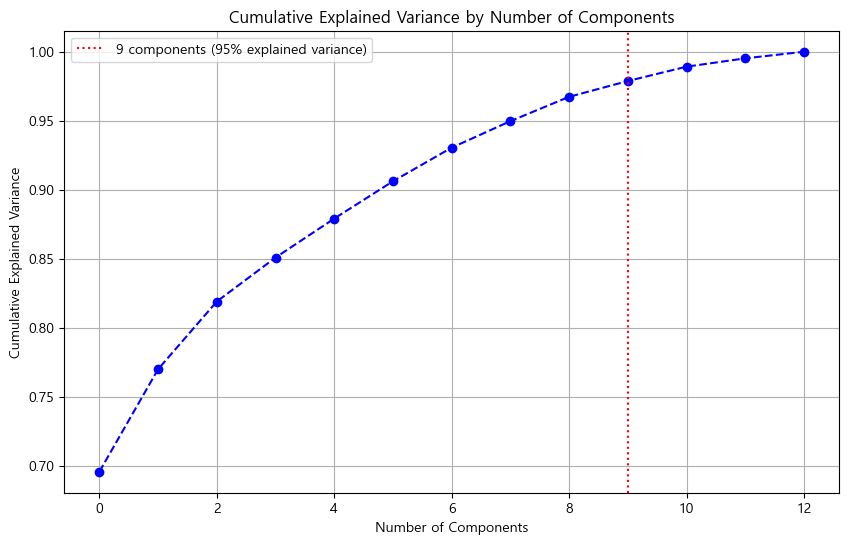

95% 이상의 설명력을 갖기 위해 9개의 주성분으로 나누어야 합니다.


In [24]:
data = pd.concat([train_df['동'], pd.get_dummies(train_df['세부사고유형'], prefix = '세부')], axis = 1).groupby('동').sum().reset_index()
X = data.drop('동', axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)

pca = PCA()
pca.fit(X)

# 누적 설명된 분산 비율 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 90% 이상 설명력을 갖는 주성분 개수 계산
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# 설명된 분산 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components (95% explained variance)')
plt.legend()
plt.grid()
plt.show()

print(f"95% 이상의 설명력을 갖기 위해 {n_components}개의 주성분으로 나누어야 합니다.")


In [25]:
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)

# 주성분으로 이루어진 DataFrame 생성
pca_columns = [f'세부_PC{i+1}' for i in range(7)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# '동' 컬럼과 PCA 결과 합치기
final_df = pd.concat([data[['동']], pca_df], axis=1)

In [26]:
train_df = train_df.merge(final_df, on = '동', how = 'left').drop(columns = '세부사고유형')
test_df = test_df.merge(final_df, on = '동', how = 'left')

---
# 법규위반 - 구별 onehot sum, pca

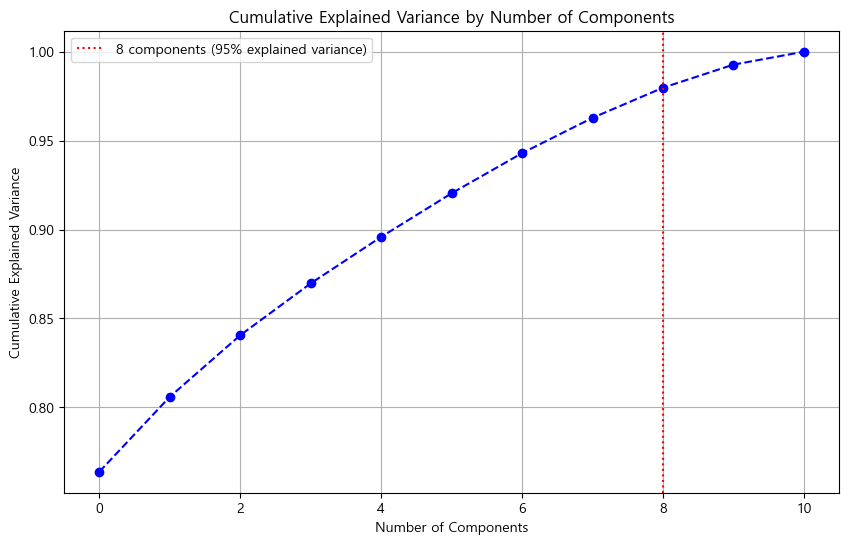

90% 이상의 설명력을 갖기 위해 8개의 주성분으로 나누어야 합니다.


In [27]:
data = pd.concat([train_df['동'], pd.get_dummies(train_df['법규위반'], prefix = '법규위반')], axis = 1).groupby('동').sum().reset_index()
X = data.drop('동', axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)

pca = PCA()
pca.fit(X)

# 누적 설명된 분산 비율 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 90% 이상 설명력을 갖는 주성분 개수 계산
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# 설명된 분산 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components (95% explained variance)')
plt.legend()
plt.grid()
plt.show()

print(f"90% 이상의 설명력을 갖기 위해 {n_components}개의 주성분으로 나누어야 합니다.")

In [28]:
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)

# 주성분으로 이루어진 DataFrame 생성
pca_columns = [f'법규_PC{i+1}' for i in range(7)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# '동' 컬럼과 PCA 결과 합치기
final_df = pd.concat([data[['동']], pca_df], axis=1)

In [29]:
train_df = train_df.merge(final_df, on = '동', how = 'left').drop(columns = '법규위반')
test_df = test_df.merge(final_df, on = '동', how = 'left')

---
# 가해운전자 차종- 구별 onehot sum, pca

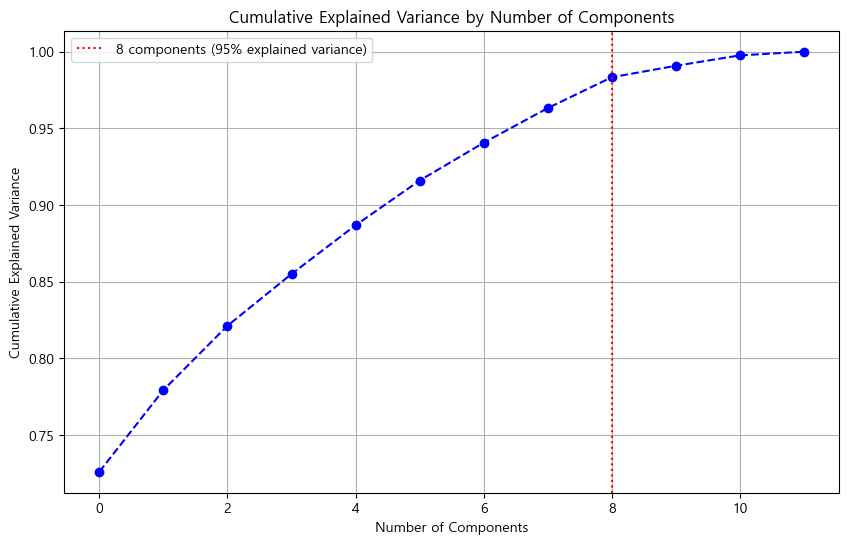

90% 이상의 설명력을 갖기 위해 8개의 주성분으로 나누어야 합니다.


In [30]:
data = pd.concat([train_df['동'], pd.get_dummies(train_df['가해운전자 차종'], prefix = '가해차종')], axis = 1).groupby('동').sum().reset_index()
X = data.drop('동', axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)

pca = PCA()
pca.fit(X)

# 누적 설명된 분산 비율 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 90% 이상 설명력을 갖는 주성분 개수 계산
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# 설명된 분산 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components (95% explained variance)')
plt.legend()
plt.grid()
plt.show()

print(f"90% 이상의 설명력을 갖기 위해 {n_components}개의 주성분으로 나누어야 합니다.")

In [31]:
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X)

# 주성분으로 이루어진 DataFrame 생성
pca_columns = [f'가해차종_PC{i+1}' for i in range(8)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# '동' 컬럼과 PCA 결과 합치기
final_df = pd.concat([data[['동']], pca_df], axis=1)

In [32]:
train_df = train_df.merge(final_df, on = '동', how = 'left').drop(columns = '가해운전자 차종')
test_df = test_df.merge(final_df, on = '동', how = 'left')

---
# 가해운전자 성별 - 구별 onehot sum

In [33]:
data = pd.concat([train_df['동'], pd.get_dummies(train_df['가해운전자 성별'], prefix = '가해성별')], axis = 1).groupby('동').sum().reset_index()
X = data.drop('동', axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data.동, X], axis = 1)

In [34]:
train_df = train_df.merge(df, on = '동', how = 'left').drop(columns = '가해운전자 성별')
test_df = test_df.merge(df, on = '동', how = 'left')

---
# 가해운전자 연령
- 미분류를 어떻게 처리할 것인가?

In [35]:
train_df['가해운전자 연령'] = train_df['가해운전자 연령'].replace('미분류', np.nan).fillna("48")
train_df['가해운전자 연령'] = train_df['가해운전자 연령'].astype('int64')

In [36]:
data = train_df.groupby('동')['가해운전자 연령'].mean().reset_index()
X = data.drop('동', axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data.동, X], axis = 1)
df.columns = ['동', '가해연령']

In [37]:
train_df = train_df.merge(df, on = '동', how = 'left').drop(columns = '가해운전자 연령')
test_df = test_df.merge(df, on = '동', how = 'left')

---
# 가해운전자 상해정도

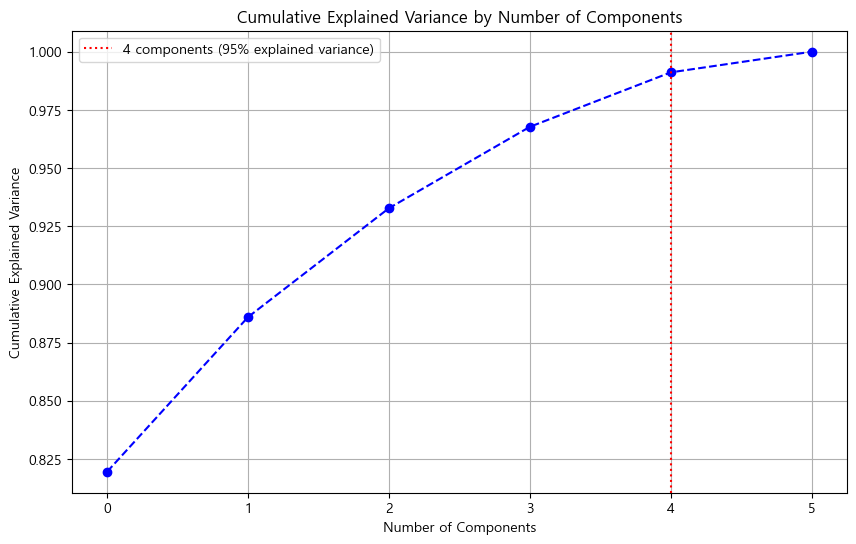

90% 이상의 설명력을 갖기 위해 4개의 주성분으로 나누어야 합니다.


In [38]:
data = pd.concat([train_df['동'], pd.get_dummies(train_df['가해운전자 상해정도'], prefix = '가해상해')], axis = 1).groupby('동').sum().reset_index()
X = data.drop('동', axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)

pca = PCA()
pca.fit(X)

# 누적 설명된 분산 비율 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 90% 이상 설명력을 갖는 주성분 개수 계산
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# 설명된 분산 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components (95% explained variance)')
plt.legend()
plt.grid()
plt.show()

print(f"90% 이상의 설명력을 갖기 위해 {n_components}개의 주성분으로 나누어야 합니다.")

In [39]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

# 주성분으로 이루어진 DataFrame 생성
pca_columns = [f'가해상해정도_PC{i+1}' for i in range(4)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# '동' 컬럼과 PCA 결과 합치기
final_df = pd.concat([data[['동']], pca_df], axis=1)

In [40]:
train_df = train_df.merge(final_df, on = '동', how = 'left').drop(columns = '가해운전자 상해정도')
test_df = test_df.merge(final_df, on = '동', how = 'left')

---
# 차량단독일 경우 피해운전자 column들이 다 null값이니 구별 null값 개수

In [41]:
data = train_df.groupby('동')['피해운전자 차종'].apply(lambda x: x.isnull().sum()).reset_index()
X = data.drop('동', axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data.동, X], axis = 1)
df.columns = ['동', 'null개수']

In [42]:
train_df = train_df.merge(df, on = '동', how = 'left')
test_df = test_df.merge(df, on = '동', how = 'left')

---
# 피해운전자 차종

In [43]:
train_notnull = train_df.loc[~train_df['피해운전자 차종'].isnull()]

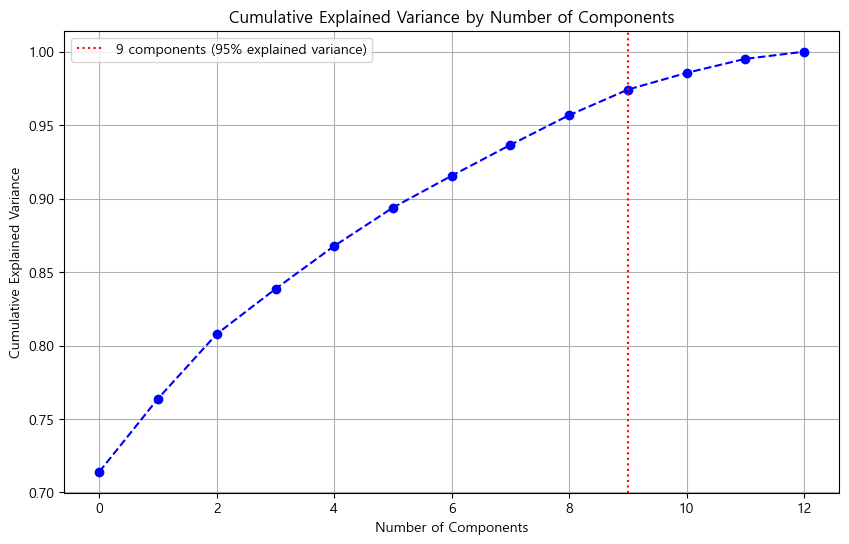

90% 이상의 설명력을 갖기 위해 9개의 주성분으로 나누어야 합니다.


In [44]:
data = pd.concat([train_notnull['동'], pd.get_dummies(train_notnull['피해운전자 차종'], prefix = '피해차종')], axis = 1).groupby('동').sum().reset_index()
X = data.drop('동', axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
pca = PCA()
pca.fit(X)

# 누적 설명된 분산 비율 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 90% 이상 설명력을 갖는 주성분 개수 계산
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# 설명된 분산 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components (95% explained variance)')
plt.legend()
plt.grid()
plt.show()

print(f"90% 이상의 설명력을 갖기 위해 {n_components}개의 주성분으로 나누어야 합니다.")

In [45]:
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X)

# 주성분으로 이루어진 DataFrame 생성
pca_columns = [f'피해차종_PC{i+1}' for i in range(8)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# '동' 컬럼과 PCA 결과 합치기
final_df = pd.concat([data[['동']], pca_df], axis=1)

In [46]:
train_df = train_df.merge(final_df, on = '동', how = 'left').drop(columns = '피해운전자 차종')
test_df = test_df.merge(final_df, on = '동', how = 'left')

---
# 피해운전자 성별

In [47]:
data = pd.concat([train_notnull['동'], pd.get_dummies(train_notnull['피해운전자 성별'], prefix = '피해성별')], axis = 1).groupby('동').sum().reset_index()
X = data.drop('동', axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data.동, X], axis = 1)

In [48]:
train_df = train_df.merge(df, on = '동', how = 'left').drop(columns = '피해운전자 성별')
test_df = test_df.merge(df, on = '동', how = 'left')

---
# 피해운전자 연령

In [49]:
train_notnull['피해운전자 연령'] = train_notnull['피해운전자 연령'].apply(lambda x : str(x).split(' ')[0])
train_notnull['피해운전자 연령'] = train_notnull['피해운전자 연령'].apply(lambda x : str(x)[:-1] if x.endswith('세') else x)

In [50]:
train_notnull['피해운전자 연령'] = train_notnull['피해운전자 연령'].replace('미분류', '45').astype('int64')

In [51]:
data = train_notnull.groupby('동')['피해운전자 연령'].mean().reset_index()
X = data.drop('동', axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data.동, X], axis = 1)
df.columns = ['동', '피해연령']

In [52]:
train_df = train_df.merge(df, on = '동', how = 'left').drop(columns = '피해운전자 연령')
test_df = test_df.merge(df, on = '동', how = 'left')

---
# 피해운전자 상해정도

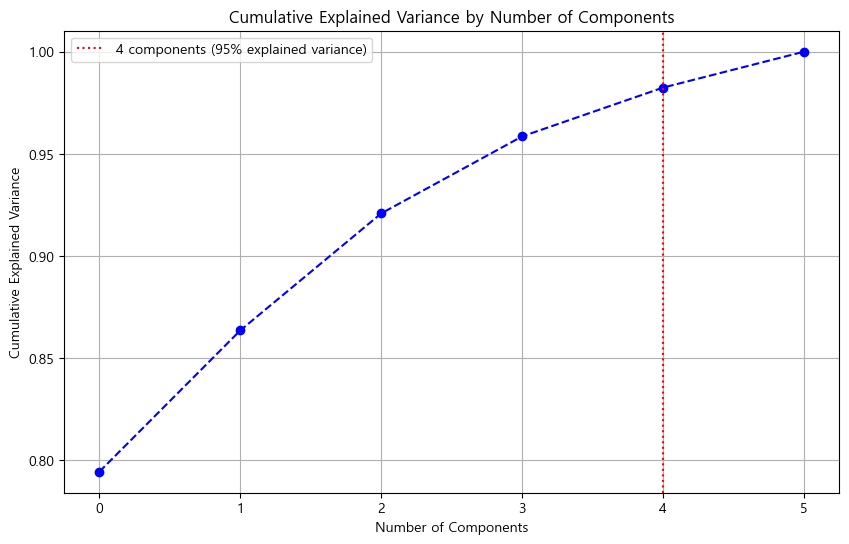

90% 이상의 설명력을 갖기 위해 4개의 주성분으로 나누어야 합니다.


In [53]:
data = pd.concat([train_notnull['동'], pd.get_dummies(train_notnull['피해운전자 상해정도'], prefix = '피해상해')], axis = 1).groupby('동').sum().reset_index()
X = data.drop('동', axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)

pca = PCA()
pca.fit(X)

# 누적 설명된 분산 비율 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 90% 이상 설명력을 갖는 주성분 개수 계산
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# 설명된 분산 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components (95% explained variance)')
plt.legend()
plt.grid()
plt.show()

print(f"90% 이상의 설명력을 갖기 위해 {n_components}개의 주성분으로 나누어야 합니다.")

In [54]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# 주성분으로 이루어진 DataFrame 생성
pca_columns = [f'피해상해정도_PC{i+1}' for i in range(3)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# '동' 컬럼과 PCA 결과 합치기
final_df = pd.concat([data[['동']], pca_df], axis=1)

In [55]:
train_df = train_df.merge(final_df, on = '동', how = 'left').drop(columns = '피해운전자 상해정도')
test_df = test_df.merge(final_df, on = '동', how = 'left')

---
# 사망자수, 중상자수, 경상자수, 부상자수
- 사망자수는 동별 집계 후 log변환
- 중상자수는 hour, 동별 집계 후 log변환
- 경상자수는 hour, 동별 집계 후 log변환
- 부상자수는 동별 집계 후 log변환

In [56]:
### 사망자수 집계 후 로그변환
data = train_df.groupby('동')['사망자수'].sum().reset_index()
X = data.drop('동', axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data.동, X], axis = 1)
df.columns = ['동', '사망자수_log']

In [57]:
train_df = train_df.merge(df, on = '동', how = 'left').drop(columns = '사망자수')
test_df = test_df.merge(df, on = '동', how = 'left')

In [58]:
### 중상자수 집계 후 로그변환
data = train_df.groupby(['hour', '동'])['중상자수'].sum().reset_index()
X = data.drop(['동', 'hour'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data[['동', 'hour']], X], axis = 1)
df.columns = ['동', 'hour', '중상자수_log']

In [59]:
train_df = train_df.merge(df, on = ['동', 'hour'], how = 'left').drop(columns = '중상자수')
test_df = test_df.merge(df, on = ['동', 'hour'], how = 'left')

In [60]:
### 중상자수 집계 후 로그변환
data = train_df.groupby(['hour', '동'])['경상자수'].sum().reset_index()
X = data.drop(['동', 'hour'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data[['동', 'hour']], X], axis = 1)
df.columns = ['동', 'hour', '경상자수_log']

In [61]:
train_df = train_df.merge(df, on = ['동', 'hour'], how = 'left').drop(columns = '경상자수')
test_df = test_df.merge(df, on = ['동', 'hour'], how = 'left')

In [62]:
### 부상자수 집계 후 로그변환
data = train_df.groupby('동')['부상자수'].sum().reset_index()
X = data.drop('동', axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data.동, X], axis = 1)
df.columns = ['동', '부상자수_log']

In [63]:
train_df = train_df.merge(df, on = '동', how = 'left').drop(columns = '부상자수')
test_df = test_df.merge(df, on = '동', how = 'left')

---
# CCTV데이터
- 도로노선방향 : one hot , sum, np.log
- 도로종류 : one hot, sum, np.log, pca
- 위도, 경도 : 구별 mean값, 
- 단속구분 : one hot, sum, np.log
- 제한속도 : 구별 mean값

In [67]:
cctv = pd.read_csv(path+'external_open/대구 CCTV 정보.csv', encoding = 'euc-kr')

In [68]:
cctv.loc[cctv['소재지도로명주소'] == "대구광역시 중구 종로 17", '소재지지번주소'] = '대구광역시 중구 종로2가'
cctv.loc[cctv['소재지도로명주소'] == "대구광역시 중구 국채보상로 713", '소재지지번주소'] = '대구광역시 중구 동인동4가'
cctv.loc[cctv['소재지도로명주소'] == "대구광역시 달성군 다사읍 세천로 1", '소재지지번주소'] = '대구광역시 달성군 다사읍 세천리 1684-4'
cctv.loc[cctv['소재지도로명주소'] == "대구광역시 달성군 가창면 가창로 1", '소재지지번주소'] = '대구광역시 달성군 가창면 삼산리 산327-9'
cctv.loc[cctv['소재지도로명주소'] == "대구광역시 달성군 논공읍 논공로 818", '소재지지번주소'] = '대구광역시 달성군 논공읍'
cctv.loc[cctv['소재지도로명주소'] == "대구광역시 달성군 논공읍 비슬로 1193", '소재지지번주소'] = '대구광역시 달성군 논공읍 하리'
cctv.loc[cctv['소재지도로명주소'] == "대구광역시 달성군 가창면 헐티로 210", '소재지지번주소'] = '대구광역시 달성군 가창면 정대리'

cctv.loc[cctv['소재지지번주소'] == "대구광역시 중구 남산동912-5", '소재지지번주소'] = '대구광역시 중구 남산동 912-5'
cctv.loc[cctv['소재지지번주소'] == "대구광역시 동구 능성동78-2", '소재지지번주소'] = '대구광역시 동구 능성동 78-2'
cctv.loc[cctv['소재지지번주소'] == "대구광역시 달서구 두류1.2동 1227-19", '소재지지번주소'] = '대구광역시 달서구 두류동'
cctv.loc[cctv['소재지지번주소'] == "대구광역시 서구 비산2.3동 60-3", '소재지지번주소'] = '대구광역시 서구 비산동 60-3'
cctv.loc[cctv['소재지지번주소'] == "대구광역시 중구 서성로1가41-3", '소재지지번주소'] = '대구광역시 중구 서성로1가 41-3'
cctv.loc[cctv['소재지지번주소'] == "대구광역시 달성군 현풍면 신기리 85-10", '소재지지번주소'] = '대구광역시 달성군 현풍읍 신기리 85-10'
cctv.loc[cctv['소재지지번주소'] == "대구광역시 달성군 북리 490-16", '소재지지번주소'] = '대구광역시 달성군 논공읍 논공로 818'
cctv.loc[cctv['소재지지번주소'] == "대구광역시 서구 비산4동 169-1", '소재지지번주소'] = '대구광역시 서구 비산동 169-1'
cctv.loc[cctv['소재지지번주소'] == "대구광역시 동구 신암4동 149-34", '소재지지번주소'] = '대구광역시 동구 신암동 149-34'
cctv.loc[cctv['소재지지번주소'] == "대구광역시 동구 신암1동 592-2", '소재지지번주소'] = '대구광역시 동구 신암동 592-2'
cctv.loc[cctv['소재지지번주소'] == "대구광역시 달성군 용계리 산86-11", '소재지지번주소'] = '대구광역시 달성군 가창면'
cctv.loc[cctv['소재지지번주소'] == "대구광역시 서구 원대동 170", '소재지지번주소'] = '대구광역시 서구 원대동1가 170'
cctv.loc[cctv['소재지지번주소'] == "대구광역시 달성군 유가면 한정리 3-4", '소재지지번주소'] = '대구광역시 달성군 유가읍 한정리 3-4'
cctv.loc[cctv['소재지지번주소'] == "대구광역시 북구 침산2동 333-3", '소재지지번주소'] = '대구광역시 북구 침산동 333-3'
cctv.loc[cctv['소재지지번주소'] == "대구광역시 서구 평리4동 1371-1", '소재지지번주소'] = '대구광역시 서구 평리동 1371-1'
cctv.loc[cctv['소재지지번주소'] == "대구광역시 달성군 매곡리 1125", '소재지지번주소'] = '대구광역시 달성군 다사읍 매곡리 1125'

In [69]:
cctv['도시'] = cctv.소재지지번주소.apply(lambda x : str(x).split(' ')[0])
cctv['구'] = cctv.소재지지번주소.apply(lambda x : str(x).split(' ')[1])
cctv['동'] = cctv.소재지지번주소.apply(lambda x : str(x).split(' ')[2])
cctv = cctv.loc[cctv['구'] != '군위군']
cctv = cctv.loc[cctv['동'] != '신안동']

---
##### 도로노선방향

In [70]:
data = pd.concat([cctv[['구', '동']], pd.get_dummies(cctv['도로노선방향'], prefix = '방향')], axis = 1).groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data[['구', '동']], X], axis = 1)

In [71]:
train_df = train_df.merge(df, on = ['구', '동'], how = 'left').fillna(0)
test_df = test_df.merge(df, on = ['구', '동'], how = 'left').fillna(0)

---
##### 도로종류

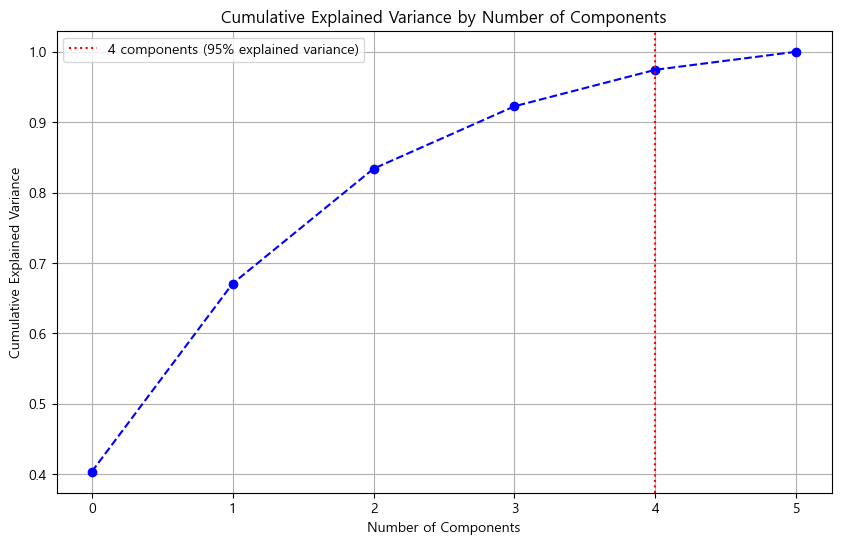

90% 이상의 설명력을 갖기 위해 4개의 주성분으로 나누어야 합니다.


In [72]:
### 도로종류 pca
data = pd.concat([cctv[['구', '동']], pd.get_dummies(cctv['도로종류'], prefix = '도로종류')], axis = 1).groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)

pca = PCA()
pca.fit(X)

# 누적 설명된 분산 비율 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 90% 이상 설명력을 갖는 주성분 개수 계산
n_components = np.argmax(cumulative_variance >= 0.90) + 1

# 설명된 분산 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components (95% explained variance)')
plt.legend()
plt.grid()
plt.show()

print(f"90% 이상의 설명력을 갖기 위해 {n_components}개의 주성분으로 나누어야 합니다.")

In [73]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

# 주성분으로 이루어진 DataFrame 생성
pca_columns = [f'도로종류_PC{i+1}' for i in range(4)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# '동' 컬럼과 PCA 결과 합치기
final_df = pd.concat([data[['구', '동']], pca_df], axis=1)

In [74]:
train_df = train_df.merge(final_df, on = ['구', '동'], how = 'left').fillna(0)
test_df = test_df.merge(final_df, on = ['구', '동'], how = 'left').fillna(0)

---
##### 단속구분

In [75]:
### 단속구분
data = pd.concat([cctv[['구', '동']], pd.get_dummies(cctv['단속구분'], prefix = '단속구분')], axis = 1).groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data[['구', '동']], X], axis = 1)

In [76]:
train_df = train_df.merge(df, on = ['구', '동'], how = 'left').fillna(0)
test_df = test_df.merge(df, on = ['구', '동'], how = 'left').fillna(0)

---
##### 위도경도

In [77]:
위도경도 = pd.read_excel('구동별위도경도_cctv.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: '구동별위도경도_cctv.xlsx'

In [78]:
위도경도

NameError: name '위도경도' is not defined

In [65]:
train_df = train_df.merge(위도경도, on = ['구', '동'], how = 'left')
test_df = test_df.merge(위도경도, on = ['구', '동'], how = 'left')

<Axes: xlabel='위도', ylabel='경도'>

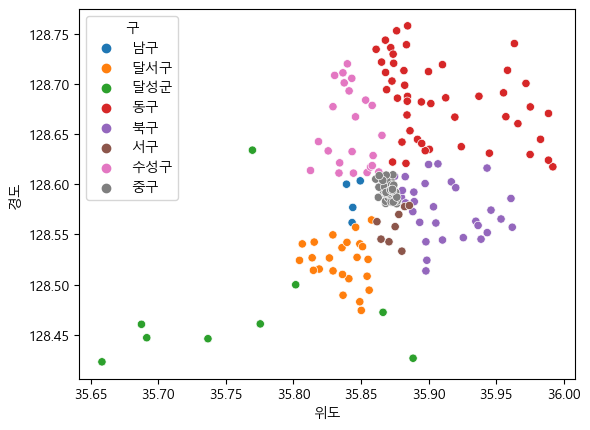

In [66]:
sns.scatterplot(data = 위도경도, x = '위도', y = '경도', hue = '구')

---
##### 제한속도

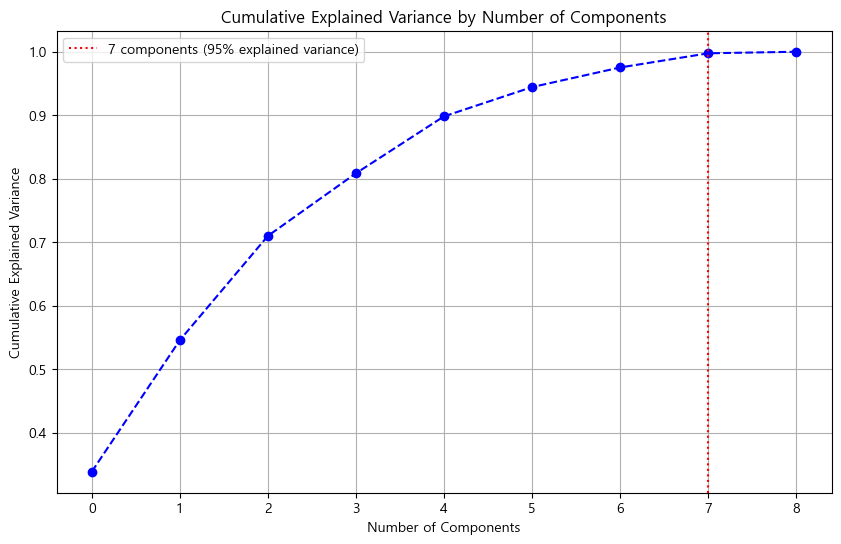

90% 이상의 설명력을 갖기 위해 7개의 주성분으로 나누어야 합니다.


In [79]:
### 제한속도 pca
data = pd.concat([cctv[['구', '동']], pd.get_dummies(cctv['제한속도'], prefix = '제한속도')], axis = 1).groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)

pca = PCA()
pca.fit(X)

# 누적 설명된 분산 비율 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 90% 이상 설명력을 갖는 주성분 개수 계산
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# 설명된 분산 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components (95% explained variance)')
plt.legend()
plt.grid()
plt.show()

print(f"90% 이상의 설명력을 갖기 위해 {n_components}개의 주성분으로 나누어야 합니다.")

In [80]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

# 주성분으로 이루어진 DataFrame 생성
pca_columns = [f'제한속도_PC{i+1}' for i in range(4)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# '동' 컬럼과 PCA 결과 합치기
final_df = pd.concat([data[['구', '동']], pca_df], axis=1)

In [81]:
train_df = train_df.merge(final_df, on = ['구', '동'], how = 'left')
test_df = test_df.merge(final_df, on = ['구', '동'], how = 'left')

In [82]:
train_df.제한속도_PC1.fillna(0, inplace = True)
train_df.제한속도_PC2.fillna(0, inplace = True)
train_df.제한속도_PC3.fillna(0, inplace = True)
train_df.제한속도_PC4.fillna(0, inplace = True)

test_df.제한속도_PC1.fillna(0, inplace = True)
test_df.제한속도_PC2.fillna(0, inplace = True)
test_df.제한속도_PC3.fillna(0, inplace = True)
test_df.제한속도_PC4.fillna(0, inplace = True)

---
# child데이터

In [84]:
child = pd.read_csv(path + 'external_open/대구 어린이 보호 구역 정보.csv', encoding = 'euc-kr')

In [85]:
child['도로명_동'] = child.소재지도로명주소.apply(lambda x : str(x).split(' ')[2])

In [86]:
child.loc[(child['도로명_동'] == "아양로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신암동'
child.loc[(child['도로명_동'] == "효동로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 효목동'
child.loc[(child['도로명_동'] == "율하동로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 율하동'
child.loc[(child['도로명_동'] == "율하동로15길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 율하동'
child.loc[(child['도로명_동'] == "안심로49길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 서호동'
child.loc[(child['도로명_동'] == "동촌로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 방촌동'
child.loc[(child['도로명_동'] == "송라로6길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신천동'
child.loc[(child['도로명_동'] == "아양로42길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 효목동'
child.loc[(child['도로명_동'] == "아양로8길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신암동'
child.loc[(child['도로명_동'] == "송라로123") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신암동'
child.loc[(child['도로명_동'] == "송라로110") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신암동'
child.loc[(child['도로명_동'] == "신암북로7길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신암동'
child.loc[(child['도로명_동'] == "동부로34길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신천동'
child.loc[(child['도로명_동'] == "파계로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 중대동'
child.loc[(child['도로명_동'] == "안심로90길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 괴전동'
child.loc[(child['도로명_동'] == "율하동로23길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 율하동'
child.loc[(child['도로명_동'] == "방천로3길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 불로동'
child.loc[(child['도로명_동'] == "신암남로45") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신암동'
child.loc[(child['도로명_동'] == "화랑로27길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 효목동'
child.loc[(child['도로명_동'] == "화랑로25길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 효목동'
child.loc[(child['도로명_동'] == "동촌로42길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 방촌동'
child.loc[(child['도로명_동'] == "동촌로48길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 방촌동'
child.loc[(child['도로명_동'] == "동북로71길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신암동'
child.loc[(child['도로명_동'] == "팔공로197길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 백안동'
child.loc[(child['도로명_동'] == "팔공로50길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 백안동'
child.loc[(child['도로명_동'] == "팔공로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 백안동'
child.loc[(child['도로명_동'] == "옻골로50") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 부동'
child.loc[(child['도로명_동'] == "숙천로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 숙천동'
child.loc[(child['도로명_동'] == "해동로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 검사동'
child.loc[(child['도로명_동'] == "파게로6길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 지묘동'
child.loc[(child['도로명_동'] == "아양로34길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신암동'
child.loc[(child['도로명_동'] == "동촌로56길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 방촌동'
child.loc[(child['도로명_동'] == "화랑로88길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 방촌동'
child.loc[(child['도로명_동'] == "큰고개로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신암동'
child.loc[(child['도로명_동'] == "율하동로20길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 율하동'
child.loc[(child['도로명_동'] == "경안로103길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 서호동'
child.loc[(child['도로명_동'] == "안심로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 동호동'
child.loc[(child['도로명_동'] == "안심로51길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 동호동'
child.loc[(child['도로명_동'] == "동호로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 동호동'
child.loc[(child['도로명_동'] == "동촌로54길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 방촌동'
child.loc[(child['도로명_동'] == "반야월북로55길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신서동'
child.loc[(child['도로명_동'] == "안심로7길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 용계동'
child.loc[(child['도로명_동'] == "동호로7길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신서동'
child.loc[(child['도로명_동'] == "율하동로8길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 율하동'
child.loc[(child['도로명_동'] == "팔공산로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 덕곡동'
child.loc[(child['도로명_동'] == "동호로2길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 동호동'
child.loc[(child['도로명_동'] == "화랑로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 용계동'
child.loc[(child['도로명_동'] == "아양로52길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 효목동'
child.loc[(child['도로명_동'] == "율하동로28길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신기동'
child.loc[(child['도로명_동'] == "율하동로26길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신기동'
child.loc[(child['도로명_동'] == "송라로3길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신천동'
child.loc[(child['도로명_동'] == "팔공로91길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 지묘동'
child.loc[(child['도로명_동'] == "율하서로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 율하동'
child.loc[(child['도로명_동'] == "안심로16길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 율하동'
child.loc[(child['도로명_동'] == "효목로19길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 효목동'
child.loc[(child['도로명_동'] == "팔공로68길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 봉무동'
child.loc[(child['도로명_동'] == "신암남로27길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신암동'
child.loc[(child['도로명_동'] == "방촌로17길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 방촌동'
child.loc[(child['도로명_동'] == "동촌로45길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 방촌동'
child.loc[(child['도로명_동'] == "송라로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신천동'
child.loc[(child['도로명_동'] == "과학로13길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 각산동'
child.loc[(child['도로명_동'] == "신암로18길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신암동'
child.loc[(child['도로명_동'] == "율하서로3길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 율하동'
child.loc[(child['도로명_동'] == "금호강변로3길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 율하동'
child.loc[(child['도로명_동'] == "신암남로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신암동'
child.loc[(child['도로명_동'] == "국채보상로165길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신천동'
child.loc[(child['도로명_동'] == "팔공로53길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 봉무동'
child.loc[(child['도로명_동'] == "효목로17길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 효목동'
child.loc[(child['도로명_동'] == "용계로1길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 용계동'
child.loc[(child['도로명_동'] == "동부로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신천동'
child.loc[(child['도로명_동'] == "반야월로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 동호동'
child.loc[(child['도로명_동'] == "신암북로") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 신암동'
child.loc[(child['도로명_동'] == "위남로2길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 봉무동'
child.loc[(child['도로명_동'] == "파계로19길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 지묘동'
child.loc[(child['도로명_동'] == "메디벨리로8길") & (child['소재지지번주소'].isnull()), '소재지지번주소'] = '대구광역시 동구 사복동'

child.loc[child['소재지지번주소'] == "대구광역시?서구?원대동3가 1120-1", '소재지지번주소'] = "대구광역시 서구 원대동3가"

In [87]:
child['도시'] = child.소재지지번주소.apply(lambda x : str(x).split(' ')[0])
child['구'] = child.소재지지번주소.apply(lambda x : str(x).split(' ')[1])
child['동'] = child.소재지지번주소.apply(lambda x : str(x).split(' ')[2])

In [88]:
child.동 = child.동.replace('옥포면', '옥포읍')
child.동 = child.동.replace('현풍면', '현풍읍')

In [89]:
child.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시설종류      640 non-null    object 
 1   대상시설명     640 non-null    object 
 2   소재지도로명주소  640 non-null    object 
 3   소재지지번주소   640 non-null    object 
 4   위도        640 non-null    float64
 5   경도        640 non-null    float64
 6   관리기관명     640 non-null    object 
 7   관할경찰서명    640 non-null    object 
 8   CCTV설치여부  640 non-null    object 
 9   CCTV설치대수  465 non-null    float64
 10  보호구역도로폭   320 non-null    object 
 11  데이터기준일자   640 non-null    object 
 12  도로명_동     640 non-null    object 
 13  도시        640 non-null    object 
 14  구         640 non-null    object 
 15  동         640 non-null    object 
dtypes: float64(3), object(13)
memory usage: 80.1+ KB


---
##### CCTV 설치여부

In [90]:
data = pd.concat([child[['구', '동']], pd.get_dummies(child['CCTV설치여부'], prefix = 'CCTV설치여부')], axis = 1).groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data[['구', '동']], X], axis = 1)

In [91]:
train_df = train_df.merge(df, on = ['구', '동'], how = 'left')
test_df = test_df.merge(df, on = ['구', '동'], how = 'left')

In [92]:
train_df.CCTV설치여부_N.fillna(0, inplace = True)
train_df.CCTV설치여부_Y.fillna(0, inplace = True)
test_df.CCTV설치여부_N.fillna(0, inplace = True)
test_df.CCTV설치여부_Y.fillna(0, inplace = True)

---
##### CCTV 설치대수

In [93]:
data = child.groupby(['구', '동'])['CCTV설치대수'].sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data[['구', '동']], X], axis = 1)

In [94]:
train_df = train_df.merge(df, on = ['구', '동'], how = 'left')
test_df = test_df.merge(df, on = ['구', '동'], how = 'left')

In [95]:
train_df['CCTV설치대수'] = train_df['CCTV설치대수'].interpolate()
test_df['CCTV설치대수'] = test_df['CCTV설치대수'].interpolate()

---
##### 시설종류

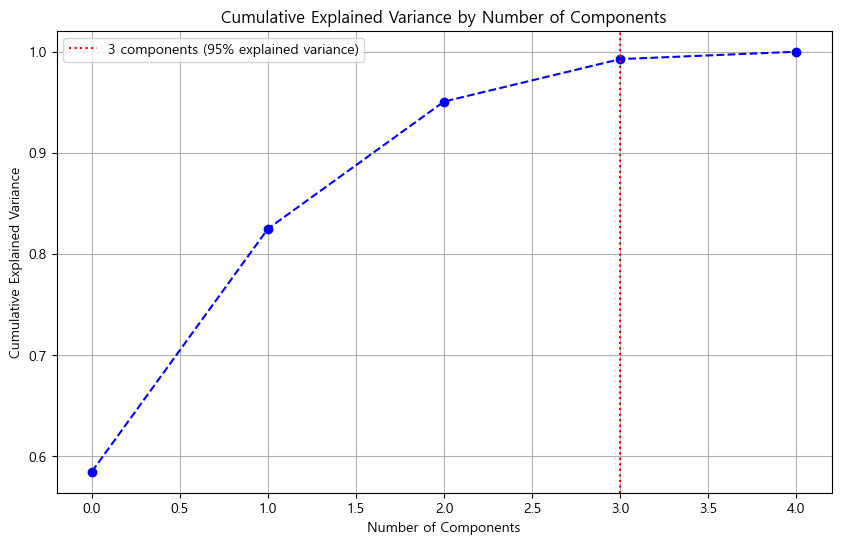

90% 이상의 설명력을 갖기 위해 3개의 주성분으로 나누어야 합니다.


In [96]:
data = pd.concat([child[['구', '동']], pd.get_dummies(child['시설종류'], prefix = '시설종류')], axis = 1).groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)

pca = PCA()
pca.fit(X)

# 누적 설명된 분산 비율 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 90% 이상 설명력을 갖는 주성분 개수 계산
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# 설명된 분산 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components (95% explained variance)')
plt.legend()
plt.grid()
plt.show()

print(f"90% 이상의 설명력을 갖기 위해 {n_components}개의 주성분으로 나누어야 합니다.")

In [97]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# 주성분으로 이루어진 DataFrame 생성
pca_columns = [f'시설종류_PC{i+1}' for i in range(3)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# '동' 컬럼과 PCA 결과 합치기
final_df = pd.concat([data[['구', '동']], pca_df], axis=1)

In [98]:
train_df = train_df.merge(final_df, on = ['구', '동'], how = 'left')
test_df = test_df.merge(final_df, on = ['구', '동'], how = 'left')

In [99]:
train_df['시설종류_PC1'] = train_df['시설종류_PC1'].interpolate()
test_df['시설종류_PC1'] = test_df['시설종류_PC1'].interpolate()
train_df['시설종류_PC2'] = train_df['시설종류_PC2'].interpolate()
test_df['시설종류_PC2'] = test_df['시설종류_PC2'].interpolate()
train_df['시설종류_PC3'] = train_df['시설종류_PC3'].interpolate()
test_df['시설종류_PC3'] = test_df['시설종류_PC3'].interpolate()

---
# 보안등 데이터
- 설치개수 : 집계 후 로그변환
- 위도 경도 파악

In [100]:
light = pd.read_csv(path+'external_open/대구 보안등 정보.csv', encoding = 'euc-kr')

In [101]:
light.loc[(light['소재지도로명주소'] == "대구광역시 동구 파계로112길 16-4"), '소재지지번주소'] = '대구광역시 동구 중대동'
light.loc[(light['소재지도로명주소'] == "대구광역시 동구 구암1길 11"), '소재지지번주소'] = '대구광역시 동구 미대동'
light.loc[(light['소재지도로명주소'] == "대구광역시 동구 팔공산로 46-3"), '소재지지번주소'] = '대구광역시 동구 공산동'
light.loc[(light['소재지도로명주소'] == "대구광역시 동구 파계호112길 20"), '소재지지번주소'] = '대구광역시 동구 중대동'
light.loc[(light['소재지도로명주소'] == "대구광역시 동구 팔공산로23길 38-15"), '소재지지번주소'] = '대구광역시 동구 송정동'
light.loc[(light['소재지도로명주소'] == "대구광역시 동구 팔공로 1505-1"), '소재지지번주소'] = '대구광역시 동구 능성동'
light.loc[(light['소재지도로명주소'] == "대구광역시 동구 도장길 47-7"), '소재지지번주소'] = '대구광역시 동구 도학동'
light.loc[(light['소재지도로명주소'] == "대구광역시 동구 팔공산로 378-19"), '소재지지번주소'] = '대구광역시 동구 송정동'
light.loc[(light['소재지도로명주소'] == "대구광역시 동구 서촌로21길 6"), '소재지지번주소'] = '대구광역시 동구 송정동'
light.loc[(light['소재지도로명주소'] == "대구광역시 동구 팔공로28길 105"), '소재지지번주소'] = '대구광역시 동구 도동'
light.loc[(light['소재지도로명주소'] == "대구광역시 동구 팔공로28길 112"), '소재지지번주소'] = '대구광역시 동구 도동'
light.loc[(light['소재지도로명주소'] == "대구광역시 동구 둔산로 467"), '소재지지번주소'] = '대구광역시 동구 도동'
light.loc[(light['소재지도로명주소'] == "대구광역시 동구 도평로 401"), '소재지지번주소'] = '대구광역시 동구 도동'
light.loc[(light['소재지도로명주소'] == "대구광역시 동구 팔공로24길 257건너편"), '소재지지번주소'] = '대구광역시 동구 도동'
light.loc[(light['소재지도로명주소'] == "대구광역시 동구 율하동로12길 23-8"), '소재지지번주소'] = '대구광역시 동구 율하동'
light.loc[(light['소재지도로명주소'] == "대구광역시 동구 율하동로28길 80"), '소재지지번주소'] = '대구광역시 동구 신기동'
light.loc[(light['소재지지번주소'] == "대구광역시 중구 동성로 3가 120-10"), '소재지지번주소'] = '대구광역시 중구 동성로3가 120-10'
light.loc[(light['소재지지번주소'] == "대구광역시 중구 동성로 3가 220-47"), '소재지지번주소'] = '대구광역시 중구 동성로3가 220-47'
light.loc[(light['소재지지번주소'] == "대구광역시 중구 동성로 3가 91-19"), '소재지지번주소'] = '대구광역시 중구 동성로3가 91-19'
light.loc[(light['소재지지번주소'] == "대구광역시 중구 동성로 1가 95-1"), '소재지지번주소'] = '대구광역시 중구 동성로1가 95-1'
light.loc[(light['소재지지번주소'] == "대구광역시 중구 삼덕동 2가 140-2"), '소재지지번주소'] = '대구광역시 중구 삼덕동2가 140-2'

In [102]:
light['소재지길이'] = light.소재지지번주소.apply(lambda x : len(str(x).split(' ')))

In [103]:
light = light.loc[light['소재지길이'] != 2]

In [104]:
light['도시'] = light.소재지지번주소.apply(lambda x : str(x).split(' ')[0])
light['구'] = light.소재지지번주소.apply(lambda x : str(x).split(' ')[1])
light['동'] = light.소재지지번주소.apply(lambda x : str(x).split(' ')[2])

In [105]:
light['동'] = light['동'].apply(lambda x: '성당동' if '성당동' in x else x)
light['동'] = light['동'].apply(lambda x: '신당동' if '신당동' in x else x)
light['동'] = light['동'].apply(lambda x: '갈산동' if '갈산동' in x else x)
light['동'] = light['동'].apply(lambda x: '두류동' if '두류동' in x else x)
light['동'] = light['동'].apply(lambda x: '본리동' if '본리동' in x else x)
light['동'] = light['동'].apply(lambda x: '송현동' if '송현동' in x else x)
light['동'] = light['동'].apply(lambda x: '호산동' if '호산동' in x else x)
light['동'] = light['동'].apply(lambda x: '월암동' if '월암동' in x else x)
light['동'] = light['동'].apply(lambda x: '대곡동' if '대곡동' in x else x)
light['동'] = light['동'].apply(lambda x: '월성동' if '월성동' in x else x)
light['동'] = light['동'].apply(lambda x: '진천동' if '진천동' in x else x)
light['동'] = light['동'].apply(lambda x: '감삼동' if '감삼동' in x else x)
light['동'] = light['동'].apply(lambda x: '이곡동' if '이곡동' in x else x)
light['동'] = light['동'].apply(lambda x: '대천동' if '대천동' in x else x)
light['동'] = light['동'].apply(lambda x: '장기동' if '장기동' in x else x)
light['동'] = light['동'].apply(lambda x: '상인동' if '상인동' in x else x)
light['동'] = light['동'].apply(lambda x: '신암동' if '신암5동' in x else x)
light['동'] = light['동'].apply(lambda x: '유가읍' if '유가면' in x else x)
light['동'] = light['동'].apply(lambda x: '침산동' if '침산3동' in x else x)
light['동'] = light['동'].apply(lambda x: '침산동' if '침산1동' in x else x)
light['동'] = light['동'].apply(lambda x: '복현동' if '복현1동' in x else x)
light['동'] = light['동'].apply(lambda x: '옥포읍' if '옥포면' in x else x)
light['동'] = light['동'].apply(lambda x: '현풍읍' if '현풍면' in x else x)
light['동'] = light['동'].apply(lambda x: '대현동' if '대현1동' in x else x)
light['동'] = light['동'].apply(lambda x: '대현동' if '대현2동' in x else x)
light['동'] = light['동'].apply(lambda x: '대현동' if '대현2동' in x else x)
light['동'] = light['동'].apply(lambda x: '산격동' if '산격1동' in x else x)
light['동'] = light['동'].apply(lambda x: '산격동' if '산격2동' in x else x)
light['동'] = light['동'].apply(lambda x: '산격동' if '산격3동' in x else x)
light['동'] = light['동'].apply(lambda x: '산격동' if '산격4동' in x else x)
light['동'] = light['동'].apply(lambda x: '태전동' if '태전1동' in x else x)
light['동'] = light['동'].apply(lambda x: '태전동' if '태전2동' in x else x)
light['동'] = light['동'].apply(lambda x: '내당동' if '내당1동' in x else x)
light['동'] = light['동'].apply(lambda x: '내당동' if '내당2동' in x else x)
light['동'] = light['동'].apply(lambda x: '내당동' if '내당3동' in x else x)
light['동'] = light['동'].apply(lambda x: '내당동' if '내당4동' in x else x)
light['동'] = light['동'].apply(lambda x: '평리동' if '평리1동' in x else x)
light['동'] = light['동'].apply(lambda x: '평리동' if '평리2동' in x else x)
light['동'] = light['동'].apply(lambda x: '평리동' if '평리3동' in x else x)
light['동'] = light['동'].apply(lambda x: '평리동' if '평리4동' in x else x)
light['동'] = light['동'].apply(lambda x: '평리동' if '평리5동' in x else x)
light['동'] = light['동'].apply(lambda x: '평리동' if '평리6동' in x else x)
light['동'] = light['동'].apply(lambda x: '만촌동' if '만촌1동' in x else x)
light['동'] = light['동'].apply(lambda x: '만촌동' if '만촌2동' in x else x)
light['동'] = light['동'].apply(lambda x: '만촌동' if '만촌3동' in x else x)
light['동'] = light['동'].apply(lambda x: '범물동' if '범물1동' in x else x)
light['동'] = light['동'].apply(lambda x: '범물동' if '범물2동' in x else x)
light['동'] = light['동'].apply(lambda x: '범어동' if '범어1동' in x else x)
light['동'] = light['동'].apply(lambda x: '범어동' if '범어2동' in x else x)
light['동'] = light['동'].apply(lambda x: '범어동' if '범어3동' in x else x)
light['동'] = light['동'].apply(lambda x: '범어동' if '범어4동' in x else x)
light['동'] = light['동'].apply(lambda x: '지산동' if '지산1동' in x else x)
light['동'] = light['동'].apply(lambda x: '지산동' if '지산2동' in x else x)
light['동'] = light['동'].apply(lambda x: '황금동' if '황금1동' in x else x)
light['동'] = light['동'].apply(lambda x: '황금동' if '황금2동' in x else x)

In [106]:
light.loc[(light['동'] == "송촌리"), '동'] = '옥포읍'
light.loc[(light['동'] == "도평로131"), '동'] = '도동'
light.loc[(light['동'] == "팔공로355-3"), '동'] = '봉무동'
light.loc[(light['동'] == "부동길162-5"), '동'] = '부동'
light.loc[(light['동'] == "988-130"), '동'] = '방촌동'
light.loc[(light['동'] == "원교리"), '동'] = '현풍읍'
light.loc[(light['동'] == "도의리"), '동'] = '유가읍'
light.loc[(light['동'] == "입석로"), '동'] = '검사동'
light.loc[(light['동'] == "유곡리"), '동'] = '유가읍'
light.loc[(light['동'] == "한정리"), '동'] = '유가읍'
light.loc[(light['동'] == "수성1가동"), '동'] = '수성동1가'
light.loc[(light['동'] == "수성2.3가동"), '동'] = '수성동2가'
light.loc[(light['동'] == "수성4가동"), '동'] = '수성동4가'

---
##### 보안등 설치개수

In [107]:
data = light.groupby(['구', '동'])['설치개수'].sum().reset_index()
data.columns = ['구', '동', '보안등설치개수']
data.보안등설치개수 = data.보안등설치개수.apply(lambda x : np.log(x))

In [108]:
train_df = train_df.merge(data, on = ['구', '동'], how = 'left')
test_df = test_df.merge(data, on = ['구', '동'], how = 'left')

In [109]:
train_df['보안등설치개수'] = train_df['보안등설치개수'].interpolate()
test_df['보안등설치개수'] = test_df['보안등설치개수'].interpolate()

---
##### 보안등 설치형태

In [110]:
data = pd.concat([light[['구', '동']], pd.get_dummies(light['설치형태'], prefix = '설치형태')], axis = 1).groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data[['구', '동']], X], axis = 1)

In [111]:
train_df = train_df.merge(df, on = ['구', '동'], how = 'left')
test_df = test_df.merge(df, on = ['구', '동'], how = 'left')

In [112]:
train_df.설치형태_건축물.fillna(0, inplace = True)
train_df.설치형태_전용주.fillna(0, inplace = True)
train_df.설치형태_한전주.fillna(0, inplace = True)
test_df.설치형태_건축물.fillna(0, inplace = True)
test_df.설치형태_전용주.fillna(0, inplace = True)
test_df.설치형태_한전주.fillna(0, inplace = True)

---
# Parking 데이터
- 주차장구분 : 이진분류 one hot sum
- 주차장유형 : 이진분류 one hot sum
- 급지구분 : one hot sum
- 운영요일 : one hot sum
- 요금정보 : one hot sum
- 평일운영시작시각 : one hot sum pca
- 평일운영종료시각 : one hot sum pca
- 토요일운영시작시각 : one hot sum pca
- 토요일운영종료시각 : one hot sum pca
- 공휴일운영시작시각 : one hot sum pca
- 공휴일운영종료시각 : one hot sum pca
- 주차기본시간 : one hot sum pca
- 주차기본요금 : one hot sum pca
- 주차구획수 : groupby sum

In [113]:
parking = pd.read_csv(path+'external_open/대구 주차장 정보.csv', encoding = 'euc-kr')

In [114]:
parking['소재지도로명주소'].fillna('대구광역시 준회구 준회동', inplace = True)

In [115]:
parking['도로명_동'] = parking['소재지도로명주소'].apply(lambda x : str(x).split(' ')[2])

In [116]:
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "상화북로"), '소재지지번주소'] = '대구광역시 달서구 상인동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "선원로"), '소재지지번주소'] = '대구광역시 달서구 신당동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "상화로"), '소재지지번주소'] = '대구광역시 달서구 상인동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "상인로"), '소재지지번주소'] = '대구광역시 달서구 상인동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "새방로"), '소재지지번주소'] = '대구광역시 달서구 용산동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "성서공단북로"), '소재지지번주소'] = '대구광역시 달서구 갈산동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "노원동2가"), '소재지지번주소'] = '대구광역시 북구 노원동2가'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "장등로"), '소재지지번주소'] = '대구광역시 동구 신천동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "송라로"), '소재지지번주소'] = '대구광역시 동구 신천동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "신암남로"), '소재지지번주소'] = '대구광역시 동구 신암동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "큰고개로"), '소재지지번주소'] = '대구광역시 동구 신암동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "명덕로2길"), '소재지지번주소'] = '대구광역시 달서구 두류동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "감삼남1길"), '소재지지번주소'] = '대구광역시 달서구 감삼동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "달구벌대로"), '소재지지번주소'] = '대구광역시 달서구 감삼동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "달구벌대로332길"), '소재지지번주소'] = '대구광역시 달서구 감삼동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "달구벌대로323길"), '소재지지번주소'] = '대구광역시 달서구 감삼동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "달구벌대로307길"), '소재지지번주소'] = '대구광역시 달서구 감삼동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "당산로30길"), '소재지지번주소'] = '대구광역시 달서구 성당동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "월곡로47길"), '소재지지번주소'] = '대구광역시 달서구 상인동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "학산로47길"), '소재지지번주소'] = '대구광역시 달서구 송현동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "와룡로51길"), '소재지지번주소'] = '대구광역시 달서구 죽전동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "와룡로45길"), '소재지지번주소'] = '대구광역시 달서구 죽전동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "대명천로11길"), '소재지지번주소'] = '대구광역시 달서구 성당동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "구마로"), '소재지지번주소'] = '대구광역시 달서구 본리동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "성서서로"), '소재지지번주소'] = '대구광역시 달서구 대천동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "성서공단로21길"), '소재지지번주소'] = '대구광역시 달서구 갈산동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "장기로"), '소재지지번주소'] = '대구광역시 달서구 성당동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "성당로"), '소재지지번주소'] = '대구광역시 달서구 성당동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "야외음악당로15길"), '소재지지번주소'] = '대구광역시 달서구 성당동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "장산남로"), '소재지지번주소'] = '대구광역시 달서구 용산동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "죽전1길"), '소재지지번주소'] = '대구광역시 달서구 죽전동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "와룡로13길"), '소재지지번주소'] = '대구광역시 달서구 죽전동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "대명천로12안길"), '소재지지번주소'] = '대구광역시 달서구 성당동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "야외음악당로"), '소재지지번주소'] = '대구광역시 달서구 성당동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "대명천로"), '소재지지번주소'] = '대구광역시 달서구 본리동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "서당로"), '소재지지번주소'] = '대구광역시 달서구 신당동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "성서동로"), '소재지지번주소'] = '대구광역시 달서구 월암동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "야외음악당로39길"), '소재지지번주소'] = '대구광역시 달서구 두류동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "상인서로"), '소재지지번주소'] = '대구광역시 달서구 상인동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "성서공단남로23길"), '소재지지번주소'] = '대구광역시 달서구 월암동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "송현로12길"), '소재지지번주소'] = '대구광역시 달서구 송현동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "월배로69길"), '소재지지번주소'] = '대구광역시 달서구 송현동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "송현로2길"), '소재지지번주소'] = '대구광역시 달서구 송현동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "중흥로"), '소재지지번주소'] = '대구광역시 달서구 송현동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "송현로8안길"), '소재지지번주소'] = '대구광역시 달서구 송현동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "선원남로"), '소재지지번주소'] = '대구광역시 달서구 이곡동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "와룡로49길"), '소재지지번주소'] = '대구광역시 달서구 죽전동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "월배로80길"), '소재지지번주소'] = '대구광역시 달서구 송현동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "용산서로"), '소재지지번주소'] = '대구광역시 달서구 용산동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "장기로26길"), '소재지지번주소'] = '대구광역시 달서구 성당동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "월곡로"), '소재지지번주소'] = '대구광역시 달서구 도원동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "상원로"), '소재지지번주소'] = '대구광역시 달서구 상인동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "월배로65길"), '소재지지번주소'] = '대구광역시 달서구 송현동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "월배로72길"), '소재지지번주소'] = '대구광역시 달서구 송현동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "송현로8길"), '소재지지번주소'] = '대구광역시 달서구 송현동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "월배로74서길"), '소재지지번주소'] = '대구광역시 달서구 송현동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "구마로40길"), '소재지지번주소'] = '대구광역시 달서구 송현동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "죽전길"), '소재지지번주소'] = '대구광역시 달서구 감삼동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "당산로41길"), '소재지지번주소'] = '대구광역시 달서구 감삼동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "와룡로54길"), '소재지지번주소'] = '대구광역시 달서구 죽전동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "중흥로16길"), '소재지지번주소'] = '대구광역시 달서구 송현동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "송현동길"), '소재지지번주소'] = '대구광역시 달서구 송현동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "송현동3길"), '소재지지번주소'] = '대구광역시 달서구 송현동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "학산로"), '소재지지번주소'] = '대구광역시 달서구 월성동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "아양로8길"), '소재지지번주소'] = '대구광역시 동구 신암동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "동부로22길"), '소재지지번주소'] = '대구광역시 동구 신천동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "화랑로25길"), '소재지지번주소'] = '대구광역시 동구 효목동'
parking.loc[(parking['소재지지번주소'].isnull()) & (parking['도로명_동'] == "경대로서19길"), '소재지지번주소'] = '대구광역시 북구 복현동'

parking.loc[parking['소재지도로명주소'] == "대구광역시 동구 동대구로 423 (신천동) 일대", '소재지지번주소'] = '대구광역시 동구 신천동'
parking.loc[parking['소재지도로명주소'] == "대구광역시 동구 동대구로 576 (신암동) ~ 덕성초등학교", '소재지지번주소'] = '대구광역시 동구 신암동'

In [117]:
parking['도시'] = parking.소재지지번주소.apply(lambda x : str(x).split(' ')[0])
parking['구'] = parking.소재지지번주소.apply(lambda x : str(x).split(' ')[1])
parking['동'] = parking.소재지지번주소.apply(lambda x : str(x).split(' ')[2])

In [118]:
parking['동'] = parking['동'].apply(lambda x: '옥포읍' if '옥포면' in x else x)
parking['동'] = parking['동'].apply(lambda x: '유가읍' if '유곡리' in x else x)
parking['동'] = parking['동'].apply(lambda x: '내당동' if '내당4동' in x else x)
parking['동'] = parking['동'].apply(lambda x: '범어동' if '범어동881-7' in x else x)
parking['동'] = parking['동'].apply(lambda x: '황금동' if '황금동672-1' in x else x)

---
##### 주차장구분

In [119]:
data = pd.concat([parking[['구', '동']], pd.get_dummies(parking['주차장구분'], prefix = '주차장구분')], axis = 1)\
.groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data[['구', '동']], X], axis = 1)

In [120]:
train_df = train_df.merge(df, on = ['구', '동'], how = 'left')
test_df = test_df.merge(df, on = ['구', '동'], how = 'left')

In [121]:
train_df['주차장구분_공영'] = train_df['주차장구분_공영'].interpolate()
test_df['주차장구분_공영'] = test_df['주차장구분_공영'].interpolate()
train_df['주차장구분_민영'] = train_df['주차장구분_민영'].interpolate()
test_df['주차장구분_민영'] = test_df['주차장구분_민영'].interpolate()

---
##### 주차장유형

In [122]:
data = pd.concat([parking[['구', '동']], pd.get_dummies(parking['주차장유형'], prefix = '주차장유형')], axis = 1)\
.groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data[['구', '동']], X], axis = 1)

In [123]:
train_df = train_df.merge(df, on = ['구', '동'], how = 'left')
test_df = test_df.merge(df, on = ['구', '동'], how = 'left')

In [124]:
train_df['주차장유형_노상'] = train_df['주차장유형_노상'].interpolate()
test_df['주차장유형_노상'] = test_df['주차장유형_노상'].interpolate()
train_df['주차장유형_노외'] = train_df['주차장유형_노외'].interpolate()
test_df['주차장유형_노외'] = test_df['주차장유형_노외'].interpolate()

---
##### 급지구분

In [125]:
data = pd.concat([parking[['구', '동']], pd.get_dummies(parking['급지구분'], prefix = '급지구분')], axis = 1)\
.groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data[['구', '동']], X], axis = 1)

In [126]:
train_df = train_df.merge(df, on = ['구', '동'], how = 'left')
test_df = test_df.merge(df, on = ['구', '동'], how = 'left')

In [127]:
train_df['급지구분_1'] = train_df['급지구분_1'].interpolate()
test_df['급지구분_1'] = test_df['급지구분_1'].interpolate()
train_df['급지구분_2'] = train_df['급지구분_2'].interpolate()
test_df['급지구분_2'] = test_df['급지구분_2'].interpolate()
train_df['급지구분_3'] = train_df['급지구분_3'].interpolate()
test_df['급지구분_3'] = test_df['급지구분_3'].interpolate()

---
##### 운영요일

In [128]:
parking['운영요일'] = parking['운영요일'].str.replace('+', '_')

In [129]:
data = pd.concat([parking[['구', '동']], pd.get_dummies(parking['운영요일'], prefix = '운영요일')], axis = 1)\
.groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data[['구', '동']], X], axis = 1)

In [130]:
train_df = train_df.merge(df, on = ['구', '동'], how = 'left')
test_df = test_df.merge(df, on = ['구', '동'], how = 'left')

In [131]:
train_df['운영요일_평일'] = train_df['운영요일_평일'].interpolate()
test_df['운영요일_평일'] = test_df['운영요일_평일'].interpolate()
train_df['운영요일_평일_토요일'] = train_df['운영요일_평일_토요일'].interpolate()
test_df['운영요일_평일_토요일'] = test_df['운영요일_평일_토요일'].interpolate()
train_df['운영요일_평일_토요일_공휴일'] = train_df['운영요일_평일_토요일_공휴일'].interpolate()
test_df['운영요일_평일_토요일_공휴일'] = test_df['운영요일_평일_토요일_공휴일'].interpolate()

---
##### 요금정보

In [132]:
data = pd.concat([parking[['구', '동']], pd.get_dummies(parking['요금정보'], prefix = '요금정보')], axis = 1)\
.groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)
df = pd.concat([data[['구', '동']], X], axis = 1)

In [133]:
train_df = train_df.merge(df, on = ['구', '동'], how = 'left')
test_df = test_df.merge(df, on = ['구', '동'], how = 'left')

In [134]:
train_df['요금정보_무료'] = train_df['요금정보_무료'].interpolate()
test_df['요금정보_무료'] = test_df['요금정보_무료'].interpolate()
train_df['요금정보_유료'] = train_df['요금정보_유료'].interpolate()
test_df['요금정보_유료'] = test_df['요금정보_유료'].interpolate()
train_df['요금정보_혼합'] = train_df['요금정보_혼합'].interpolate()
test_df['요금정보_혼합'] = test_df['요금정보_혼합'].interpolate()

---
##### 평일운영시작시각

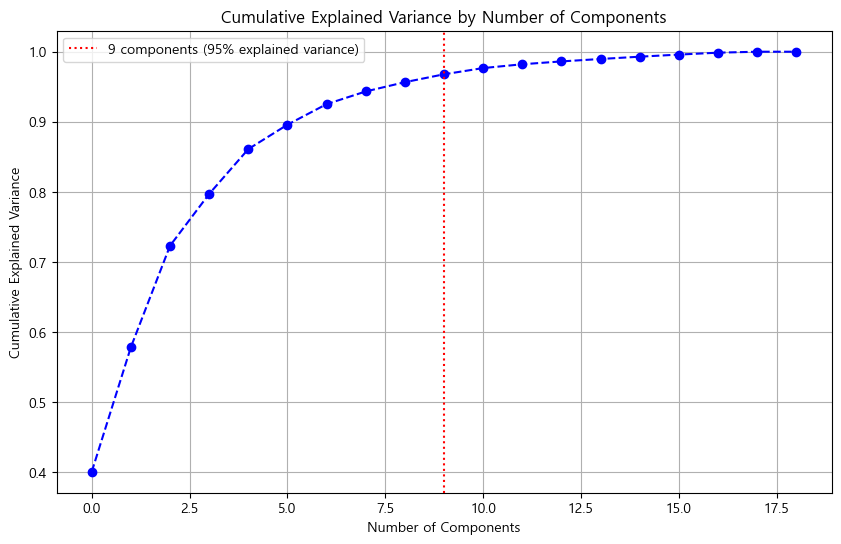

90% 이상의 설명력을 갖기 위해 9개의 주성분으로 나누어야 합니다.


In [135]:
data = pd.concat([parking[['구', '동']], pd.get_dummies(parking['평일운영시작시각'], prefix = '평일운영시작시각')], axis = 1).groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)

pca = PCA()
pca.fit(X)

# 누적 설명된 분산 비율 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 90% 이상 설명력을 갖는 주성분 개수 계산
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# 설명된 분산 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components (95% explained variance)')
plt.legend()
plt.grid()
plt.show()

print(f"90% 이상의 설명력을 갖기 위해 {n_components}개의 주성분으로 나누어야 합니다.")

In [136]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X)

# 주성분으로 이루어진 DataFrame 생성
pca_columns = [f'평일운영시작시각_PC{i+1}' for i in range(6)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# '동' 컬럼과 PCA 결과 합치기
final_df = pd.concat([data[['구', '동']], pca_df], axis=1)

In [137]:
train_df = train_df.merge(final_df, on = ['구', '동'], how = 'left')
test_df = test_df.merge(final_df, on = ['구', '동'], how = 'left')

In [138]:
train_df['평일운영시작시각_PC1'] = train_df['평일운영시작시각_PC1'].interpolate()
test_df['평일운영시작시각_PC1'] = test_df['평일운영시작시각_PC1'].interpolate()
train_df['평일운영시작시각_PC2'] = train_df['평일운영시작시각_PC2'].interpolate()
test_df['평일운영시작시각_PC2'] = test_df['평일운영시작시각_PC2'].interpolate()
train_df['평일운영시작시각_PC3'] = train_df['평일운영시작시각_PC3'].interpolate()
test_df['평일운영시작시각_PC3'] = test_df['평일운영시작시각_PC3'].interpolate()
train_df['평일운영시작시각_PC4'] = train_df['평일운영시작시각_PC4'].interpolate()
test_df['평일운영시작시각_PC4'] = test_df['평일운영시작시각_PC4'].interpolate()
train_df['평일운영시작시각_PC5'] = train_df['평일운영시작시각_PC5'].interpolate()
test_df['평일운영시작시각_PC5'] = test_df['평일운영시작시각_PC5'].interpolate()
train_df['평일운영시작시각_PC6'] = train_df['평일운영시작시각_PC6'].interpolate()
test_df['평일운영시작시각_PC6'] = test_df['평일운영시작시각_PC6'].interpolate()

---
##### 평일운영종료시각

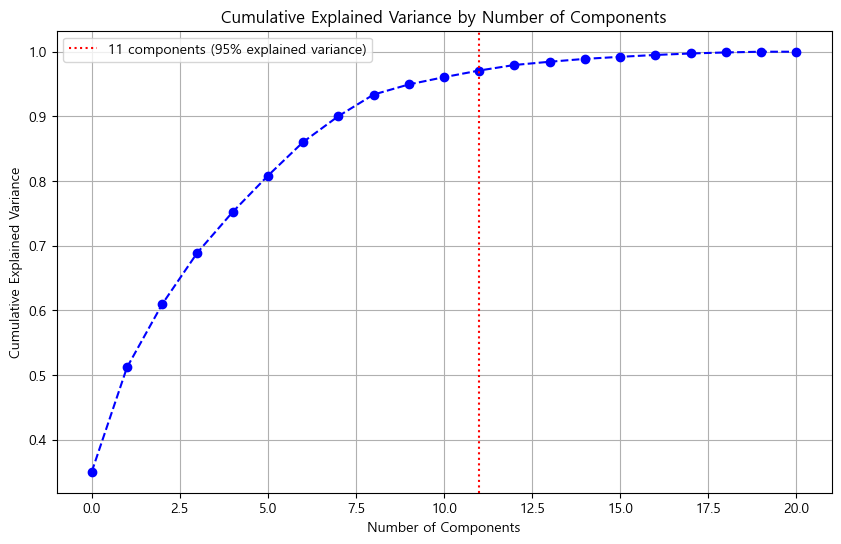

90% 이상의 설명력을 갖기 위해 11개의 주성분으로 나누어야 합니다.


In [139]:
data = pd.concat([parking[['구', '동']], pd.get_dummies(parking['평일운영종료시각'], prefix = '평일운영종료시각')], axis = 1).groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)

pca = PCA()
pca.fit(X)

# 누적 설명된 분산 비율 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 90% 이상 설명력을 갖는 주성분 개수 계산
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# 설명된 분산 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components (95% explained variance)')
plt.legend()
plt.grid()
plt.show()

print(f"90% 이상의 설명력을 갖기 위해 {n_components}개의 주성분으로 나누어야 합니다.")

In [140]:
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X)

# 주성분으로 이루어진 DataFrame 생성
pca_columns = [f'평일운영종료시각_PC{i+1}' for i in range(8)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# '동' 컬럼과 PCA 결과 합치기
final_df = pd.concat([data[['구', '동']], pca_df], axis=1)

In [141]:
train_df = train_df.merge(final_df, on = ['구', '동'], how = 'left')
test_df = test_df.merge(final_df, on = ['구', '동'], how = 'left')

In [142]:
train_df['평일운영종료시각_PC1'] = train_df['평일운영종료시각_PC1'].interpolate()
test_df['평일운영종료시각_PC1'] = test_df['평일운영종료시각_PC1'].interpolate()
train_df['평일운영종료시각_PC2'] = train_df['평일운영종료시각_PC2'].interpolate()
test_df['평일운영종료시각_PC2'] = test_df['평일운영종료시각_PC2'].interpolate()
train_df['평일운영종료시각_PC3'] = train_df['평일운영종료시각_PC3'].interpolate()
test_df['평일운영종료시각_PC3'] = test_df['평일운영종료시각_PC3'].interpolate()
train_df['평일운영종료시각_PC4'] = train_df['평일운영종료시각_PC4'].interpolate()
test_df['평일운영종료시각_PC4'] = test_df['평일운영종료시각_PC4'].interpolate()
train_df['평일운영종료시각_PC5'] = train_df['평일운영종료시각_PC5'].interpolate()
test_df['평일운영종료시각_PC5'] = test_df['평일운영종료시각_PC5'].interpolate()
train_df['평일운영종료시각_PC6'] = train_df['평일운영종료시각_PC6'].interpolate()
test_df['평일운영종료시각_PC6'] = test_df['평일운영종료시각_PC6'].interpolate()
train_df['평일운영종료시각_PC7'] = train_df['평일운영종료시각_PC7'].interpolate()
test_df['평일운영종료시각_PC7'] = test_df['평일운영종료시각_PC7'].interpolate()
train_df['평일운영종료시각_PC8'] = train_df['평일운영종료시각_PC8'].interpolate()
test_df['평일운영종료시각_PC8'] = test_df['평일운영종료시각_PC8'].interpolate()

---
##### 토요일운영시작시각

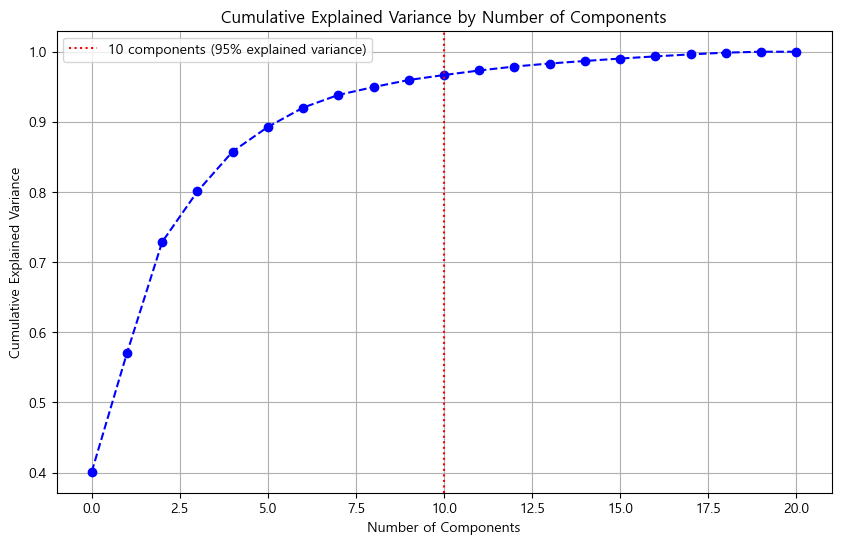

90% 이상의 설명력을 갖기 위해 10개의 주성분으로 나누어야 합니다.


In [143]:
data = pd.concat([parking[['구', '동']], pd.get_dummies(parking['토요일운영시작시각'], prefix = '토요일운영시작시각')], axis = 1).groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)

pca = PCA()
pca.fit(X)

# 누적 설명된 분산 비율 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 90% 이상 설명력을 갖는 주성분 개수 계산
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# 설명된 분산 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components (95% explained variance)')
plt.legend()
plt.grid()
plt.show()

print(f"90% 이상의 설명력을 갖기 위해 {n_components}개의 주성분으로 나누어야 합니다.")

In [145]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X)

# 주성분으로 이루어진 DataFrame 생성
pca_columns = [f'토요일운영시작시각_PC{i+1}' for i in range(6)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# '동' 컬럼과 PCA 결과 합치기
final_df = pd.concat([data[['구', '동']], pca_df], axis=1)

In [146]:
train_df = train_df.merge(final_df, on = ['구', '동'], how = 'left')
test_df = test_df.merge(final_df, on = ['구', '동'], how = 'left')

In [147]:
train_df['토요일운영시작시각_PC1'] = train_df['토요일운영시작시각_PC1'].interpolate()
test_df['토요일운영시작시각_PC1'] = test_df['토요일운영시작시각_PC1'].interpolate()
train_df['토요일운영시작시각_PC2'] = train_df['토요일운영시작시각_PC2'].interpolate()
test_df['토요일운영시작시각_PC2'] = test_df['토요일운영시작시각_PC2'].interpolate()
train_df['토요일운영시작시각_PC3'] = train_df['토요일운영시작시각_PC3'].interpolate()
test_df['토요일운영시작시각_PC3'] = test_df['토요일운영시작시각_PC3'].interpolate()
train_df['토요일운영시작시각_PC4'] = train_df['토요일운영시작시각_PC4'].interpolate()
test_df['토요일운영시작시각_PC4'] = test_df['토요일운영시작시각_PC4'].interpolate()
train_df['토요일운영시작시각_PC5'] = train_df['토요일운영시작시각_PC5'].interpolate()
test_df['토요일운영시작시각_PC5'] = test_df['토요일운영시작시각_PC5'].interpolate()
train_df['토요일운영시작시각_PC6'] = train_df['토요일운영시작시각_PC6'].interpolate()
test_df['토요일운영시작시각_PC6'] = test_df['토요일운영시작시각_PC6'].interpolate()

---
##### 토요일운영종료시각

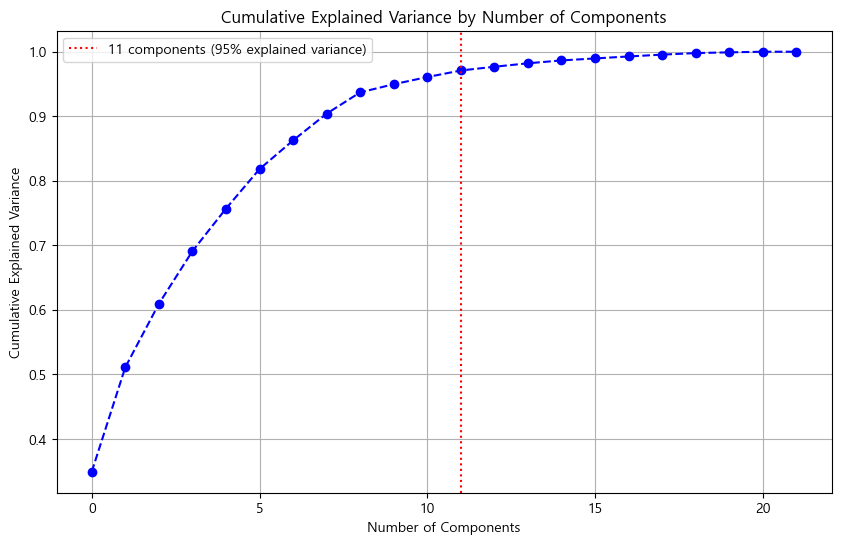

90% 이상의 설명력을 갖기 위해 11개의 주성분으로 나누어야 합니다.


In [148]:
data = pd.concat([parking[['구', '동']], pd.get_dummies(parking['토요일운영종료시각'], prefix = '토요일운영종료시각')], axis = 1).groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)

pca = PCA()
pca.fit(X)

# 누적 설명된 분산 비율 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 90% 이상 설명력을 갖는 주성분 개수 계산
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# 설명된 분산 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components (95% explained variance)')
plt.legend()
plt.grid()
plt.show()

print(f"90% 이상의 설명력을 갖기 위해 {n_components}개의 주성분으로 나누어야 합니다.")

In [149]:
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X)

# 주성분으로 이루어진 DataFrame 생성
pca_columns = [f'토요일운영종료시각_PC{i+1}' for i in range(8)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# '동' 컬럼과 PCA 결과 합치기
final_df = pd.concat([data[['구', '동']], pca_df], axis=1)

In [150]:
train_df = train_df.merge(final_df, on = ['구', '동'], how = 'left')
test_df = test_df.merge(final_df, on = ['구', '동'], how = 'left')

In [151]:
train_df['토요일운영종료시각_PC1'] = train_df['토요일운영종료시각_PC1'].interpolate()
test_df['토요일운영종료시각_PC1'] = test_df['토요일운영종료시각_PC1'].interpolate()
train_df['토요일운영종료시각_PC2'] = train_df['토요일운영종료시각_PC2'].interpolate()
test_df['토요일운영종료시각_PC2'] = test_df['토요일운영종료시각_PC2'].interpolate()
train_df['토요일운영종료시각_PC3'] = train_df['토요일운영종료시각_PC3'].interpolate()
test_df['토요일운영종료시각_PC3'] = test_df['토요일운영종료시각_PC3'].interpolate()
train_df['토요일운영종료시각_PC4'] = train_df['토요일운영종료시각_PC4'].interpolate()
test_df['토요일운영종료시각_PC4'] = test_df['토요일운영종료시각_PC4'].interpolate()
train_df['토요일운영종료시각_PC5'] = train_df['토요일운영종료시각_PC5'].interpolate()
test_df['토요일운영종료시각_PC5'] = test_df['토요일운영종료시각_PC5'].interpolate()
train_df['토요일운영종료시각_PC6'] = train_df['토요일운영종료시각_PC6'].interpolate()
test_df['토요일운영종료시각_PC6'] = test_df['토요일운영종료시각_PC6'].interpolate()
train_df['토요일운영종료시각_PC7'] = train_df['토요일운영종료시각_PC7'].interpolate()
test_df['토요일운영종료시각_PC7'] = test_df['토요일운영종료시각_PC7'].interpolate()
train_df['토요일운영종료시각_PC8'] = train_df['토요일운영종료시각_PC8'].interpolate()
test_df['토요일운영종료시각_PC8'] = test_df['토요일운영종료시각_PC8'].interpolate()

---
##### 공휴일운영시작시각

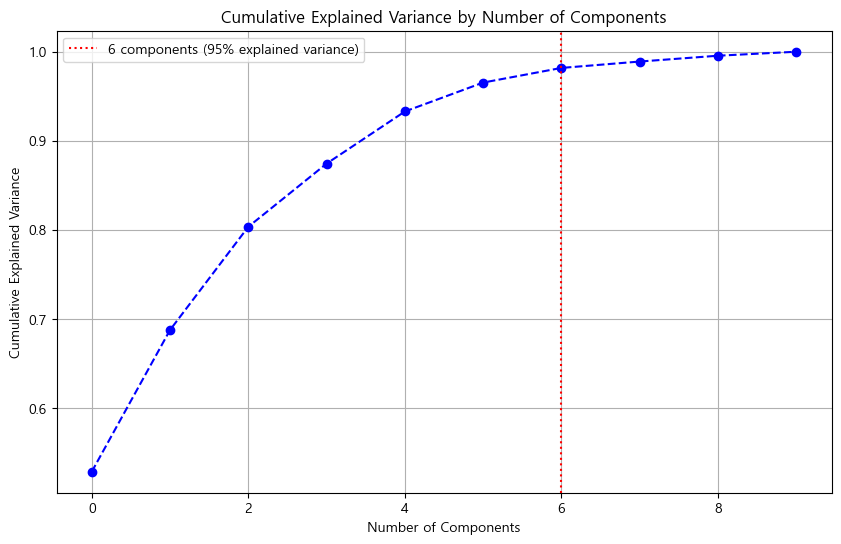

90% 이상의 설명력을 갖기 위해 6개의 주성분으로 나누어야 합니다.


In [152]:
data = pd.concat([parking[['구', '동']], pd.get_dummies(parking['공휴일운영시작시각'], prefix = '공휴일운영시작시각')], axis = 1).groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)

pca = PCA()
pca.fit(X)

# 누적 설명된 분산 비율 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 90% 이상 설명력을 갖는 주성분 개수 계산
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# 설명된 분산 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components (95% explained variance)')
plt.legend()
plt.grid()
plt.show()

print(f"90% 이상의 설명력을 갖기 위해 {n_components}개의 주성분으로 나누어야 합니다.")

In [153]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# 주성분으로 이루어진 DataFrame 생성
pca_columns = [f'공휴일운영시작시각_PC{i+1}' for i in range(5)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# '동' 컬럼과 PCA 결과 합치기
final_df = pd.concat([data[['구', '동']], pca_df], axis=1)

In [154]:
train_df = train_df.merge(final_df, on = ['구', '동'], how = 'left')
test_df = test_df.merge(final_df, on = ['구', '동'], how = 'left')

In [155]:
train_df['공휴일운영시작시각_PC1'] = train_df['공휴일운영시작시각_PC1'].interpolate()
test_df['공휴일운영시작시각_PC1'] = test_df['공휴일운영시작시각_PC1'].interpolate()
train_df['공휴일운영시작시각_PC2'] = train_df['공휴일운영시작시각_PC2'].interpolate()
test_df['공휴일운영시작시각_PC2'] = test_df['공휴일운영시작시각_PC2'].interpolate()
train_df['공휴일운영시작시각_PC3'] = train_df['공휴일운영시작시각_PC3'].interpolate()
test_df['공휴일운영시작시각_PC3'] = test_df['공휴일운영시작시각_PC3'].interpolate()
train_df['공휴일운영시작시각_PC4'] = train_df['공휴일운영시작시각_PC4'].interpolate()
test_df['공휴일운영시작시각_PC4'] = test_df['공휴일운영시작시각_PC4'].interpolate()
train_df['공휴일운영시작시각_PC5'] = train_df['공휴일운영시작시각_PC5'].interpolate()
test_df['공휴일운영시작시각_PC5'] = test_df['공휴일운영시작시각_PC5'].interpolate()

---
##### 공휴일운영종료시각

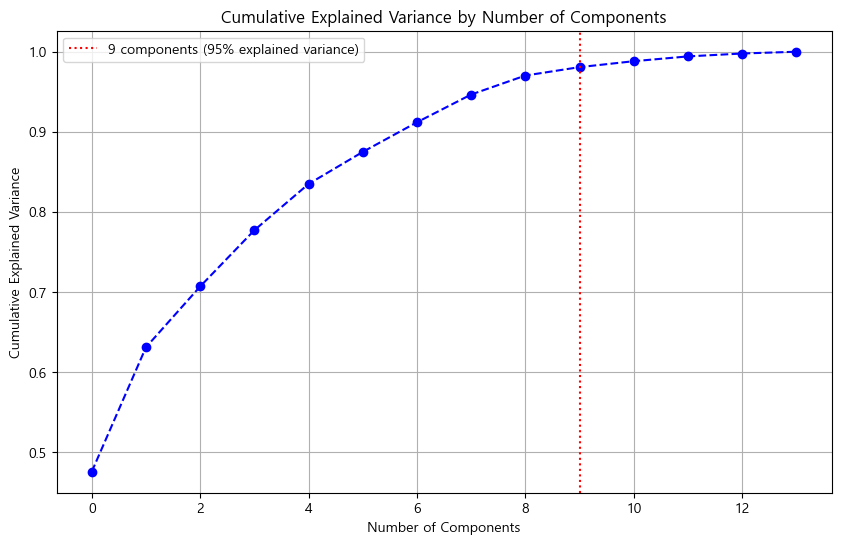

90% 이상의 설명력을 갖기 위해 9개의 주성분으로 나누어야 합니다.


In [156]:
data = pd.concat([parking[['구', '동']], pd.get_dummies(parking['공휴일운영종료시각'], prefix = '공휴일운영종료시각')], axis = 1).groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)

pca = PCA()
pca.fit(X)

# 누적 설명된 분산 비율 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 90% 이상 설명력을 갖는 주성분 개수 계산
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# 설명된 분산 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components (95% explained variance)')
plt.legend()
plt.grid()
plt.show()

print(f"90% 이상의 설명력을 갖기 위해 {n_components}개의 주성분으로 나누어야 합니다.")

In [157]:
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X)

# 주성분으로 이루어진 DataFrame 생성
pca_columns = [f'공휴일운영종료시각_PC{i+1}' for i in range(8)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# '동' 컬럼과 PCA 결과 합치기
final_df = pd.concat([data[['구', '동']], pca_df], axis=1)

In [158]:
train_df = train_df.merge(final_df, on = ['구', '동'], how = 'left')
test_df = test_df.merge(final_df, on = ['구', '동'], how = 'left')

In [159]:
train_df['공휴일운영종료시각_PC1'] = train_df['공휴일운영종료시각_PC1'].interpolate()
test_df['공휴일운영종료시각_PC1'] = test_df['공휴일운영종료시각_PC1'].interpolate()
train_df['공휴일운영종료시각_PC2'] = train_df['공휴일운영종료시각_PC2'].interpolate()
test_df['공휴일운영종료시각_PC2'] = test_df['공휴일운영종료시각_PC2'].interpolate()
train_df['공휴일운영종료시각_PC3'] = train_df['공휴일운영종료시각_PC3'].interpolate()
test_df['공휴일운영종료시각_PC3'] = test_df['공휴일운영종료시각_PC3'].interpolate()
train_df['공휴일운영종료시각_PC4'] = train_df['공휴일운영종료시각_PC4'].interpolate()
test_df['공휴일운영종료시각_PC4'] = test_df['공휴일운영종료시각_PC4'].interpolate()
train_df['공휴일운영종료시각_PC5'] = train_df['공휴일운영종료시각_PC5'].interpolate()
test_df['공휴일운영종료시각_PC5'] = test_df['공휴일운영종료시각_PC5'].interpolate()
train_df['공휴일운영종료시각_PC6'] = train_df['공휴일운영종료시각_PC6'].interpolate()
test_df['공휴일운영종료시각_PC6'] = test_df['공휴일운영종료시각_PC6'].interpolate()
train_df['공휴일운영종료시각_PC7'] = train_df['공휴일운영종료시각_PC7'].interpolate()
test_df['공휴일운영종료시각_PC7'] = test_df['공휴일운영종료시각_PC7'].interpolate()
train_df['공휴일운영종료시각_PC8'] = train_df['공휴일운영종료시각_PC8'].interpolate()
test_df['공휴일운영종료시각_PC8'] = test_df['공휴일운영종료시각_PC8'].interpolate()

---
##### 주차기본시간

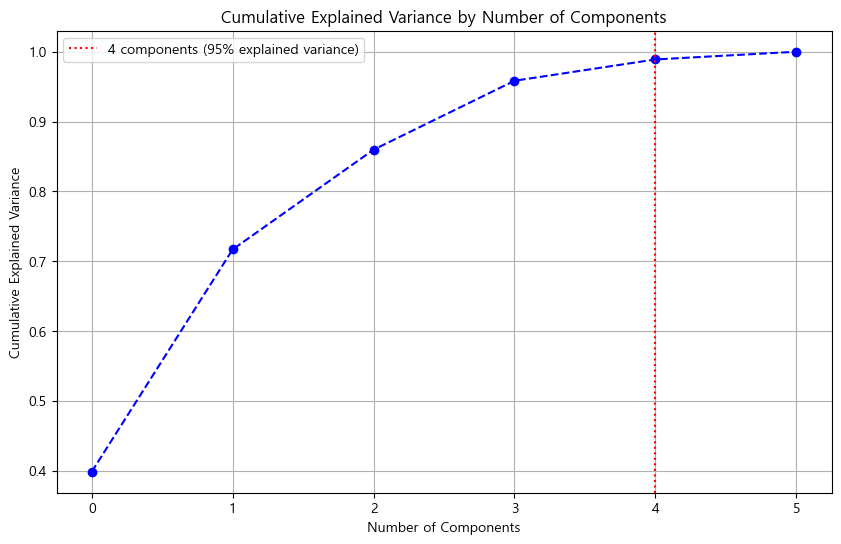

90% 이상의 설명력을 갖기 위해 4개의 주성분으로 나누어야 합니다.


In [160]:
data = pd.concat([parking[['구', '동']], pd.get_dummies(parking['주차기본시간'], prefix = '주차기본시간')], axis = 1).groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)

pca = PCA()
pca.fit(X)

# 누적 설명된 분산 비율 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 90% 이상 설명력을 갖는 주성분 개수 계산
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# 설명된 분산 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components (95% explained variance)')
plt.legend()
plt.grid()
plt.show()

print(f"90% 이상의 설명력을 갖기 위해 {n_components}개의 주성분으로 나누어야 합니다.")

In [161]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# 주성분으로 이루어진 DataFrame 생성
pca_columns = [f'주차기본시간_PC{i+1}' for i in range(3)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# '동' 컬럼과 PCA 결과 합치기
final_df = pd.concat([data[['구', '동']], pca_df], axis=1)

In [162]:
train_df = train_df.merge(final_df, on = ['구', '동'], how = 'left')
test_df = test_df.merge(final_df, on = ['구', '동'], how = 'left')

In [163]:
train_df['주차기본시간_PC1'] = train_df['주차기본시간_PC1'].interpolate()
test_df['주차기본시간_PC1'] = test_df['주차기본시간_PC1'].interpolate()
train_df['주차기본시간_PC2'] = train_df['주차기본시간_PC2'].interpolate()
test_df['주차기본시간_PC2'] = test_df['주차기본시간_PC2'].interpolate()
train_df['주차기본시간_PC3'] = train_df['주차기본시간_PC3'].interpolate()
test_df['주차기본시간_PC3'] = test_df['주차기본시간_PC3'].interpolate()

---
##### 주차기본요금

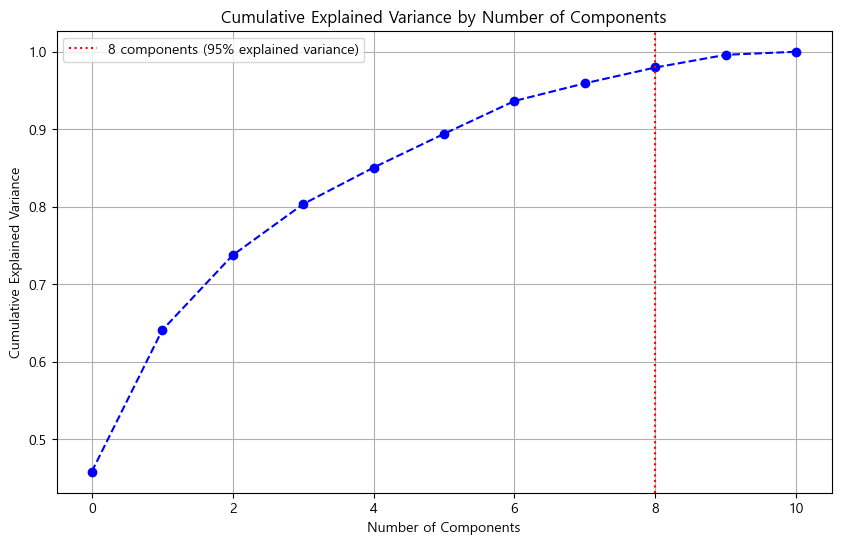

90% 이상의 설명력을 갖기 위해 8개의 주성분으로 나누어야 합니다.


In [164]:
data = pd.concat([parking[['구', '동']], pd.get_dummies(parking['주차기본요금'], prefix = '주차기본요금')], axis = 1).groupby(['구', '동']).sum().reset_index()
X = data.drop(['구', '동'], axis=1)
X = X.applymap(lambda x : x*10).applymap(np.log)
X = X.replace([np.inf, -np.inf, np.nan], 0)

pca = PCA()
pca.fit(X)

# 누적 설명된 분산 비율 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 90% 이상 설명력을 갖는 주성분 개수 계산
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# 설명된 분산 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axvline(x=n_components, color='r', linestyle=':', label=f'{n_components} components (95% explained variance)')
plt.legend()
plt.grid()
plt.show()

print(f"90% 이상의 설명력을 갖기 위해 {n_components}개의 주성분으로 나누어야 합니다.")

In [165]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X)

# 주성분으로 이루어진 DataFrame 생성
pca_columns = [f'주차기본요금_PC{i+1}' for i in range(6)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# '동' 컬럼과 PCA 결과 합치기
final_df = pd.concat([data[['구', '동']], pca_df], axis=1)

In [166]:
train_df = train_df.merge(final_df, on = ['구', '동'], how = 'left')
test_df = test_df.merge(final_df, on = ['구', '동'], how = 'left')

In [167]:
train_df['주차기본요금_PC1'] = train_df['주차기본요금_PC1'].interpolate()
test_df['주차기본요금_PC1'] = test_df['주차기본요금_PC1'].interpolate()
train_df['주차기본요금_PC2'] = train_df['주차기본요금_PC2'].interpolate()
test_df['주차기본요금_PC2'] = test_df['주차기본요금_PC2'].interpolate()
train_df['주차기본요금_PC3'] = train_df['주차기본요금_PC3'].interpolate()
test_df['주차기본요금_PC3'] = test_df['주차기본요금_PC3'].interpolate()
train_df['주차기본요금_PC4'] = train_df['주차기본요금_PC4'].interpolate()
test_df['주차기본요금_PC4'] = test_df['주차기본요금_PC4'].interpolate()
train_df['주차기본요금_PC5'] = train_df['주차기본요금_PC5'].interpolate()
test_df['주차기본요금_PC5'] = test_df['주차기본요금_PC5'].interpolate()
train_df['주차기본요금_PC6'] = train_df['주차기본요금_PC6'].interpolate()
test_df['주차기본요금_PC6'] = test_df['주차기본요금_PC6'].interpolate()

---
##### 주차구획수

In [168]:
data = parking.groupby(['구', '동'])['주차구획수'].sum().reset_index()
data.columns = ['구', '동', '주차구획수']
data.주차구획수 = data.주차구획수.apply(lambda x : np.log(x))

In [169]:
train_df = train_df.merge(data, on = ['구', '동'], how = 'left')
test_df = test_df.merge(data, on = ['구', '동'], how = 'left')

In [170]:
train_df['주차구획수'] = train_df['주차구획수'].interpolate()
test_df['주차구획수'] = test_df['주차구획수'].interpolate()

In [171]:
train_df['위도'] = train_df['위도'].interpolate()
test_df['위도'] = test_df['위도'].interpolate()
train_df['경도'] = train_df['경도'].interpolate()
test_df['경도'] = test_df['경도'].interpolate()

KeyError: '위도'

---
# 구별인구증감률 데이터

In [158]:
pop = pd.read_excel('구별인구증감률.xlsx')

In [159]:
pop = pop.iloc[:,1:]

In [160]:
pop['year'] = pop.시점.apply(lambda x : str(x).split('.')[0])
pop['month'] = pop.시점.apply(lambda x : str(x).split('.')[1])
pop.drop(columns = '시점', inplace = True)

In [161]:
pop.year = pop.year.astype('int64')
pop.month = pop.month.astype('int64')

In [162]:
pop

,구,남자인구수,남자인구수_전월대비,남자인구수_증감률,여자인구수,여자인구수_전월대비,여자인구수_증감률,year,month
0,중구,38381,-117,-0.3,40811,-92,-0.2,2019,1
1,동구,173874,-81,0.0,177381,45,0.0,2019,1
2,서구,92511,-285,-0.3,91266,-310,-0.3,2019,1
3,남구,72536,-128,-0.2,77680,-157,-0.2,2019,1
4,북구,218984,-323,-0.1,219902,-280,-0.1,2019,1
...,...,...,...,...,...,...,...,...,...
283,남구,68799,-267,-0.4,74376,-203,-0.3,2021,12
284,북구,217420,231,0.1,219588,210,0.1,2021,12
285,수성구,201689,-448,-0.2,215408,-469,-0.2,2021,12
286,달서구,268498,-595,-0.2,276428,-462,-0.2,2021,12


In [163]:
te = pop.drop(columns = 'year').groupby(['구', 'month']).mean().reset_index()

In [164]:
train_df = train_df.merge(pop, on = ['year', 'month', '구'], how = 'left')
test_df = test_df.merge(te, on = ['month', '구'], how = 'left')

In [173]:
# Mean target encoding
yo_mean_target_encoded = train_df.groupby('요일')['ECLO'].mean()
sea_mean_target_encoded = train_df.groupby('season')['ECLO'].mean()
ki_mean_target_encoded = train_df.groupby('기상상태')['ECLO'].mean()
do_accident_mean_target_encoded = train_df.groupby('도로형태')['ECLO'].mean()
no_mean_target_encoded = train_df.groupby('노면상태')['ECLO'].mean()
sa_mean_target_encoded = train_df.groupby('사고유형')['ECLO'].mean()
gu_mean_target_encoded = train_df.groupby('구')['ECLO'].mean()
dong_mean_target_encoded = train_df.groupby('동')['ECLO'].mean()

In [166]:
train_df['요일']=train_df['요일'].map(yo_mean_target_encoded)
train_df['season']=train_df['season'].map(sea_mean_target_encoded)
train_df['기상상태']=train_df['기상상태'].map(ki_mean_target_encoded)
train_df['도로형태']=train_df['도로형태'].map(do_accident_mean_target_encoded)
train_df['노면상태']=train_df['노면상태'].map(no_mean_target_encoded)
train_df['사고유형']=train_df['사고유형'].map(sa_mean_target_encoded)
train_df['구']=train_df['구'].map(gu_mean_target_encoded)
train_df['동']=train_df['동'].map(dong_mean_target_encoded)

In [174]:
test_df['요일']=test_df['요일'].map(yo_mean_target_encoded)
test_df['season']=test_df['season'].map(sea_mean_target_encoded)
test_df['기상상태']=test_df['기상상태'].map(ki_mean_target_encoded)
test_df['도로형태']=test_df['도로형태'].map(do_accident_mean_target_encoded)
test_df['노면상태']=test_df['노면상태'].map(no_mean_target_encoded)
test_df['사고유형']=test_df['사고유형'].map(sa_mean_target_encoded)
test_df['구']=test_df['구'].map(gu_mean_target_encoded)
test_df['동']=test_df['동'].map(dong_mean_target_encoded)

In [168]:
'''encoder = BinaryEncoder()
cols = ['요일', 'season', '기상상태', '도로형태', '노면상태', '사고유형', '구']
train_df = pd.concat([train_df, encoder.fit_transform(train_df[cols], train_df['ECLO'])], axis = 1).drop(columns = [
    '요일', 'season', '기상상태', '도로형태', '노면상태', '사고유형', '구'])
test_df = pd.concat([test_df, encoder.fit_transform(test_df[cols])], axis = 1).drop(columns = [
    '요일', 'season', '기상상태', '도로형태', '노면상태', '사고유형', '구'])'''

"encoder = BinaryEncoder()\ncols = ['요일', 'season', '기상상태', '도로형태', '노면상태', '사고유형', '구']\ntrain_df = pd.concat([train_df, encoder.fit_transform(train_df[cols], train_df['ECLO'])], axis = 1).drop(columns = [\n    '요일', 'season', '기상상태', '도로형태', '노면상태', '사고유형', '구'])\ntest_df = pd.concat([test_df, encoder.fit_transform(test_df[cols])], axis = 1).drop(columns = [\n    '요일', 'season', '기상상태', '도로형태', '노면상태', '사고유형', '구'])"

In [169]:
'''encoder = TargetEncoder()
target = encoder.fit_transform(train_df['동'], train_df['ECLO'])
target_te = encoder.transform(test_df['동'])

train_df.drop(columns = '동', inplace = True)
test_df.drop(columns = '동', inplace = True)

train_df = pd.concat([train_df, target], axis = 1)
test_df = pd.concat([test_df, target_te], axis = 1)'''

"encoder = TargetEncoder()\ntarget = encoder.fit_transform(train_df['동'], train_df['ECLO'])\ntarget_te = encoder.transform(test_df['동'])\n\ntrain_df.drop(columns = '동', inplace = True)\ntest_df.drop(columns = '동', inplace = True)\n\ntrain_df = pd.concat([train_df, target], axis = 1)\ntest_df = pd.concat([test_df, target_te], axis = 1)"

In [175]:
train_df.shape, test_df.shape

((39608, 152), (10963, 151))

In [176]:
X_train = train_df.drop(columns = 'ECLO')
y_train = train_df.ECLO.apply(lambda x : np.log(x))
X_test = test_df

In [177]:
### 스케일링 진행 ###

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test),columns=X_test.columns)

ValueError: could not convert string to float: '화요일'

In [173]:
# 중상자수_log, 경상자수_log, hour, 동, 여자인구수_전월대비, day, 사고유형_1, month, year, 요일_0, 시설종류_PC1, 도로형태_3, 남자인구수
# 남자인구수_전월대비, 도로형태_2, 

In [174]:
#X_train = X_train[['중상자수_log', '경상자수_log', 'hour', '동', '여자인구수_전월대비', 'day', '사고유형_1', 'month', 'year',
#                   '요일_0', '시설종류_PC1', '도로형태_3', '남자인구수', '남자인구수_전월대비', '도로형태_2']]
#X_test = X_test[['중상자수_log', '경상자수_log', 'hour', '동', '여자인구수_전월대비', 'day', '사고유형_1', 'month', 'year', '요일_0',
#                 '시설종류_PC1', '도로형태_3', '남자인구수', '남자인구수_전월대비', '도로형태_2']]

---
# Catboost 모델

In [172]:
from sklearn.model_selection import train_test_split, KFold, cross_validate
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
# 최적화된 하이퍼파라미터로 OOF를 수행하여 최종 CatBoost 모형 생성:
# No tuning => tuning한 모델에 비해 성능이 떨어지지 않음

#sscv = ShuffleSplit(test_size=.3334, n_splits=5, random_state=0)
models = cross_validate(CatBoostRegressor(verbose=False, random_state=0),
                        X_train, y_train, 
                        cv=5, 
                        scoring='neg_mean_squared_log_error', 
                        return_estimator=True)
oof_pred = np.array([m.predict(X_test) for m in models['estimator']]).mean(axis=0)

scores = models['test_score']
print("\nCatBoost CV scores: ", np.sqrt(-1*scores))
print("CatBoost CV mean = %.2f" % np.sqrt(-1*scores.mean()), "with std = %.2f" % np.sqrt(scores.std()))

NameError: name 'X_train' is not defined

In [176]:
oof_pred

array([0.98673049, 1.11030251, 1.56145235, ..., 1.13224355, 1.50900384,
       1.45917834])

---
# Lgbm 모델

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_validate
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
# 최적화된 하이퍼파라미터로 OOF를 수행하여 최종 CatBoost 모형 생성:
# No tuning => tuning한 모델에 비해 성능이 떨어지지 않음

#sscv = ShuffleSplit(test_size=.3334, n_splits=5, random_state=0)
models = cross_validate(LGBMRegressor(verbose=-1, random_state=0),
                        X_train, y_train, 
                        cv=5, 
                        scoring='neg_mean_squared_log_error', 
                        return_estimator=True)
oof_pred = np.array([m.predict(X_test) for m in models['estimator']]).mean(axis=0)

scores = models['test_score']
print("\nCatBoost CV scores: ", np.sqrt(-1*scores))
print("CatBoost CV mean = %.2f" % np.sqrt(-1*scores.mean()), "with std = %.2f" % np.sqrt(scores.std()))

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['ECLO'] = oof_pred

In [ ]:
sample_submission.to_csv('lgbm_20231129.csv', index = False)

In [ ]:
import shap
model = LGBMRegressor(verbose = -1)  # 또는 분류 모델인 경우 xgb.XGBClassifier() 사용
model.fit(X_train, y_train)

# Shap 값 계산
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_train)

# 각 특성의 중요도 시각화
shap.summary_plot(shap_values, X_train, plot_type='bar')

---
# Dense 모델

In [ ]:
import tensorflow as tf

def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))

    return tf.sqrt(tf.reduce_mean(squared_error))

def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

In [ ]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

In [ ]:
def create_model():

    input_layer = tf.keras.Input(shape=(len(X_train.columns), ))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=loss_fn,
                  metrics=[metric_fn]
                  )

    return model

model = create_model()
history = model.fit(X_train.astype('float32'), y_train.astype('float32'),
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_split=0.1)

In [ ]:
# train loss, val loss 시각화
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')

sample_submission["ECLO"] = model.predict(X_test.astype('float32'))

In [ ]:
sample_submission

In [ ]:
sample_submission.to_csv("dense_20231129.csv", index=False)

---
# XGB 모델

In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import numpy as np

# RMSLE 계산 함수 정의
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2)))

# Objective 함수 정의
def objective(trial):
    # XGBoost 하이퍼파라미터 탐색 공간
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_loguniform('eta', 1e-3, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'random_state' : trial.suggest_int('random_state', 1, 5000)
    }

    # XGBoost 모델 정의
    model = xgb.XGBRegressor(**param)

    # RMSLE를 평가 지표로 사용하기 위한 Scorer 생성
    rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

    # cross_val_score를 통한 교차 검증
    scores = -cross_val_score(model, X_train, y_train, cv=5, scoring=rmsle_scorer)

    return scores.mean()  # 교차 검증 결과의 평균 RMSLE 반환

# Optuna Study 생성
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 최적의 하이퍼파라미터 출력
print('Best trial:')
trial = study.best_trial
print('RMSLE: {}'.format(trial.value))
print("Best parameters:", trial.params)

In [ ]:
model = XGBRegressor(**study.best_params)
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [ ]:
pred

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['ECLO'] = pred

In [ ]:
# sample_submission.to_csv('XGB_20231130_1640.csv', index = False)

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_validate
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
# 최적화된 하이퍼파라미터로 OOF를 수행하여 최종 CatBoost 모형 생성:
# No tuning => tuning한 모델에 비해 성능이 떨어지지 않음

#sscv = ShuffleSplit(test_size=.3334, n_splits=5, random_state=0)
models = cross_validate(XGBRegressor(**study.best_params),
                        X_train, y_train, 
                        cv=5, 
                        scoring='neg_mean_squared_log_error', 
                        return_estimator=True)
oof_pred = np.array([m.predict(X_test) for m in models['estimator']]).mean(axis=0)

scores = models['test_score']
print("\nCatBoost CV scores: ", np.sqrt(-1*scores))
print("CatBoost CV mean = %.2f" % np.sqrt(-1*scores.mean()), "with std = %.2f" % np.sqrt(scores.std()))

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['ECLO'] = oof_pred
sample_submission.to_csv('XGB_stacking_20231130_1700.csv', index = False)

In [ ]:
sample_submission

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# 모델 생성 및 훈련
model = xgb.XGBRegressor(**study.best_params)
model.fit(X_train, y_train)

# Feature Importance 시각화
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=20)  # 상위 10개 feature만 표시
plt.show()

In [ ]:
import shap
plt.figure(figsize=(10, 8))
model = XGBRegressor(params = study.best_params)
model.fit(X_train, y_train)

# Shap 값 계산
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_train)

# 각 특성의 중요도 시각화
shap.summary_plot(shap_values, X_train, plot_type='bar')